
# Phishing URL Detection System






## 1. Install Required Packages


In [2]:
!pip install tldextract


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.4/107.4 kB 8.0 MB/s eta 0:00:00




## 2. Imports and Setup


In [3]:
import warnings
import pandas as pd
import numpy as np
from urllib.parse import urlparse
import tldextract
import re
from datetime import datetime
from google.colab import drive
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.svm import SVC
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                           f1_score, roc_auc_score, confusion_matrix,
                           classification_report, PrecisionRecallDisplay,
                           RocCurveDisplay, ConfusionMatrixDisplay)
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import json
from sklearn.base import BaseEstimator, TransformerMixin

# Suppress warnings
warnings.filterwarnings('ignore')

## 3. Data Loading with Error Handling

In [4]:
def load_data(file_path):
    """Load and validate the dataset with proper error handling"""
    try:
        df = pd.read_csv(file_path)

        # Basic validation
        if df.empty:
            raise ValueError("Dataset is empty")
        if 'label' not in df.columns:
            raise ValueError("Target variable 'label' missing")
        if 'URL' not in df.columns:
            raise ValueError("URL column missing")

        # URL validation
        def is_valid_url(url):
            try:
                result = urlparse(str(url))
                return all([result.scheme, result.netloc])
            except:
                return False

        df['is_valid_url'] = df['URL'].apply(is_valid_url)
        invalid_count = len(df[~df['is_valid_url']])
        if invalid_count > 0:
            print(f"Warning: Found {invalid_count} invalid URLs. They will be removed.")
            df = df[df['is_valid_url']].copy()

        # Remove duplicates
        df = df.drop_duplicates('URL', keep='first')

        return df

    except Exception as e:
        print(f"Error loading data: {str(e)}")
        return None

# Load data - replace with your actual path
try:
    from google.colab import drive
    drive.mount('/content/drive')
    file_path = '/content/drive/My Drive/PhiUSIIL_Phishing_URL_Dataset.csv'
    df = load_data(file_path)

    if df is None:
        raise ValueError("Data loading failed. Please check the file path.")

    print("\nData loaded successfully. Shape:", df.shape)
    print("\nFirst 5 rows:")
    display(df.head())

except Exception as e:
    print(f"Initialization error: {str(e)}")
    print("Please make sure:")
    print("1. You're using Google Colab or have the file locally")
    print("2. The file path is correct")
    print("3. The file exists and is accessible")
    df = None

Mounted at /content/drive

Data loaded successfully. Shape: (235370, 57)

First 5 rows:


,FILENAME,URL,URLLength,Domain,DomainLength,IsDomainIP,TLD,URLSimilarityIndex,CharContinuationRate,TLDLegitimateProb,...,Crypto,HasCopyrightInfo,NoOfImage,NoOfCSS,NoOfJS,NoOfSelfRef,NoOfEmptyRef,NoOfExternalRef,label,is_valid_url
0,521848.txt,https://www.southbankmosaics.com,31,www.southbankmosaics.com,24,0,com,100.0,1.000000,0.522907,...,0,1,34,20,28,119,0,124,1,True
1,31372.txt,https://www.uni-mainz.de,23,www.uni-mainz.de,16,0,de,100.0,0.666667,0.032650,...,0,1,50,9,8,39,0,217,1,True
2,597387.txt,https://www.voicefmradio.co.uk,29,www.voicefmradio.co.uk,22,0,uk,100.0,0.866667,0.028555,...,0,1,10,2,7,42,2,5,1,True
3,554095.txt,https://www.sfnmjournal.com,26,www.sfnmjournal.com,19,0,com,100.0,1.000000,0.522907,...,1,1,3,27,15,22,1,31,1,True
4,151578.txt,https://www.rewildingargentina.org,33,www.rewildingargentina.org,26,0,org,100.0,1.000000,0.079963,...,0,1,244,15,34,72,1,85,1,True


#DATA OVERVIEW

In [5]:
# Basic info
print("BASIC INFO:")
df.info()
print("\n")

BASIC INFO:
<class 'pandas.core.frame.DataFrame'>
Index: 235370 entries, 0 to 235794
Data columns (total 57 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   FILENAME                    235370 non-null  object 
 1   URL                         235370 non-null  object 
 2   URLLength                   235370 non-null  int64  
 3   Domain                      235370 non-null  object 
 4   DomainLength                235370 non-null  int64  
 5   IsDomainIP                  235370 non-null  int64  
 6   TLD                         235370 non-null  object 
 7   URLSimilarityIndex          235370 non-null  float64
 8   CharContinuationRate        235370 non-null  float64
 9   TLDLegitimateProb           235370 non-null  float64
 10  URLCharProb                 235370 non-null  float64
 11  TLDLength                   235370 non-null  int64  
 12  NoOfSubDomain               235370 non-null  int64  
 13  HasObfu

In [6]:
# Print shape of the DataFrame
print("DATA SHAPE (rows, columns):")
print(df.shape)

DATA SHAPE (rows, columns):
(235370, 57)


#Exploratory Data Analysis (EDA)

GENERAL EDA

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set seaborn style
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)

DESCRIPTIVE STATISTICS

In [8]:
# Descriptive statistics for numeric columns
print("DESCRIPTIVE STATISTICS:")
print(df.describe().T, "\n")


DESCRIPTIVE STATISTICS:
                               count          mean            std        min  \
URLLength                   235370.0     34.545516      41.332730  13.000000   
DomainLength                235370.0     21.456022       9.127733   4.000000   
IsDomainIP                  235370.0      0.002702       0.051912   0.000000   
URLSimilarityIndex          235370.0     78.497537      28.947899   0.155574   
CharContinuationRate        235370.0      0.845900       0.216384   0.000000   
TLDLegitimateProb           235370.0      0.260503       0.251618   0.000000   
URLCharProb                 235370.0      0.055760       0.010583   0.001083   
TLDLength                   235370.0      2.764269       0.599667   2.000000   
NoOfSubDomain               235370.0      1.164957       0.600695   0.000000   
HasObfuscation              235370.0      0.002052       0.045254   0.000000   
NoOfObfuscatedChar          235370.0      0.024880       1.877922   0.000000   
ObfuscationRatio

In [9]:
# Descriptive statistics for object (categorical/text) columns
print("CATEGORICAL COLUMNS SUMMARY:")
print(df.select_dtypes(include='object').describe().T, "\n")

CATEGORICAL COLUMNS SUMMARY:
           count  unique                                 top    freq
FILENAME  235370  235370                          384822.txt       1
URL       235370  235370  https://www.alternativefinland.com       1
Domain    235370  220086                             ipfs.io    1192
TLD       235370     695                                 com  112382
Title     235370  197782                                   0   32617 



In [10]:
# Value counts for target variable
print("LABEL DISTRIBUTION:")
print(df['label'].value_counts(), "\n")

LABEL DISTRIBUTION:
label
1    134850
0    100520
Name: count, dtype: int64 



DATA VISUALIZATIONS

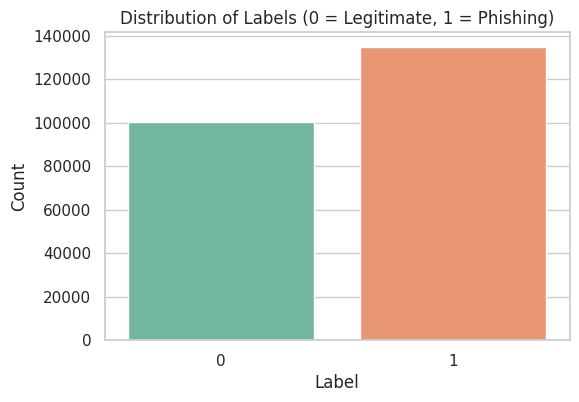

In [11]:
# Distribution of target class
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x='label', palette='Set2')
plt.title('Distribution of Labels (0 = Legitimate, 1 = Phishing)')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()


In [12]:
# Compute correlation matrix for numeric columns
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
correlation = df[numeric_cols].corr()

# Correlation with the target variable
label_corr = correlation['label'].drop('label')  # Remove self-correlation

# Filter correlations with abs(corr) >= 0.3 (you can adjust threshold)
high_corr = label_corr[abs(label_corr) >= 0.3].sort_values(ascending=False)

In [13]:


# Print highly correlated features with 'label'
print("Highly Correlated Features with 'label' (|correlation| >= 0.3):\n")
print(high_corr, "\n")


Highly Correlated Features with 'label' (|correlation| >= 0.3):

URLSimilarityIndex            0.860342
HasSocialNet                  0.783882
HasCopyrightInfo              0.743197
HasDescription                0.690011
IsHTTPS                       0.610253
DomainTitleMatchScore         0.584204
HasSubmitButton               0.578816
IsResponsive                  0.548977
URLTitleMatchScore            0.538844
HasHiddenFields               0.507715
HasFavicon                    0.493607
URLCharProb                   0.469521
CharContinuationRate          0.467162
HasTitle                      0.460337
Robots                        0.392461
NoOfJS                        0.373162
Pay                           0.359724
NoOfSelfRef                   0.315867
NoOfOtherSpecialCharsInURL   -0.358268
LetterRatioInURL             -0.366970
DegitRatioInURL              -0.431896
SpacialCharRatioInURL        -0.533003
Name: label, dtype: float64 



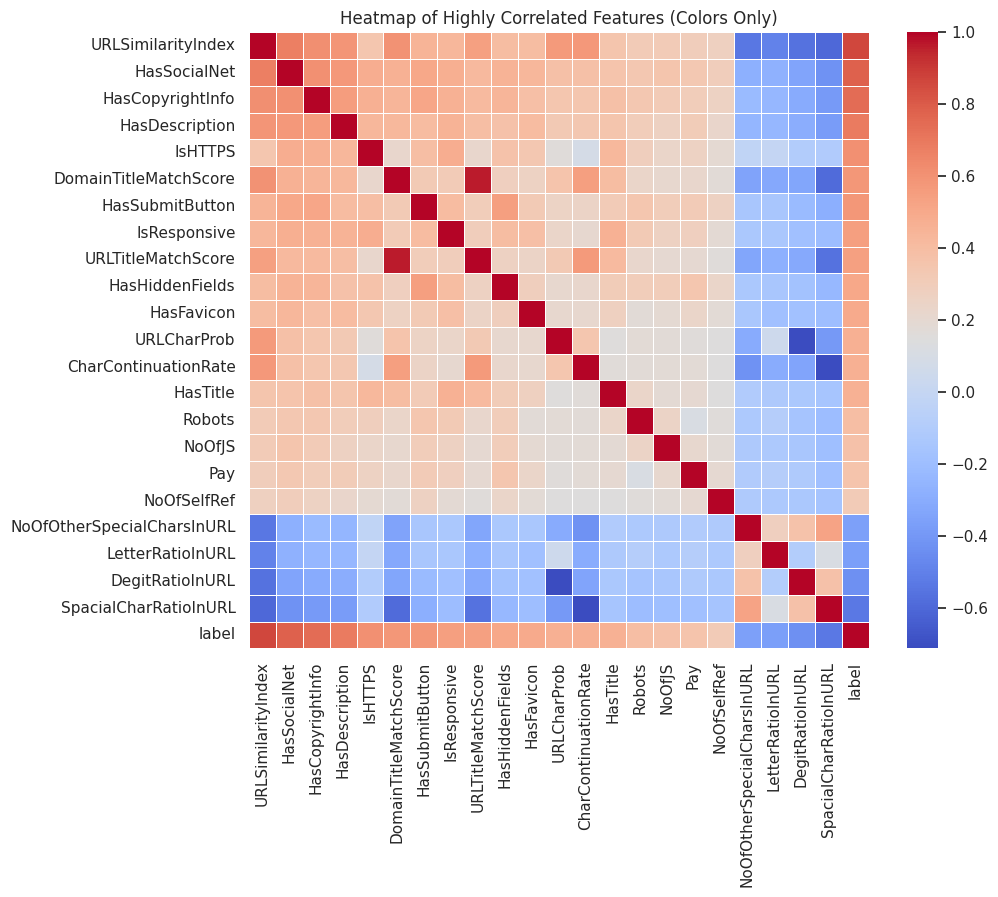

In [14]:
high_corr_features = high_corr.index.tolist() + ['label']
plt.figure(figsize=(10, 8))
sns.heatmap(df[high_corr_features].corr(), cmap='coolwarm', annot=False, linewidths=0.5)
plt.title('Heatmap of Highly Correlated Features (Colors Only)')
plt.show()

In [15]:
# Top 10 highly correlated features with the label
corr_with_label = correlation['label'].drop('label').sort_values(ascending=False)
print("TOP FEATURES POSITIVELY CORRELATED WITH 'label':")
print(corr_with_label.head(10), "\n")
print("TOP FEATURES NEGATIVELY CORRELATED WITH 'label':")
print(corr_with_label.tail(10), "\n")

TOP FEATURES POSITIVELY CORRELATED WITH 'label':
URLSimilarityIndex       0.860342
HasSocialNet             0.783882
HasCopyrightInfo         0.743197
HasDescription           0.690011
IsHTTPS                  0.610253
DomainTitleMatchScore    0.584204
HasSubmitButton          0.578816
IsResponsive             0.548977
URLTitleMatchScore       0.538844
HasHiddenFields          0.507715
Name: label, dtype: float64 

TOP FEATURES NEGATIVELY CORRELATED WITH 'label':
TLDLength                    -0.078973
NoOfQMarkInURL               -0.176027
NoOfDegitsInURL              -0.177755
URLLength                    -0.233060
NoOfLettersInURL             -0.257626
DomainLength                 -0.282643
NoOfOtherSpecialCharsInURL   -0.358268
LetterRatioInURL             -0.366970
DegitRatioInURL              -0.431896
SpacialCharRatioInURL        -0.533003
Name: label, dtype: float64 



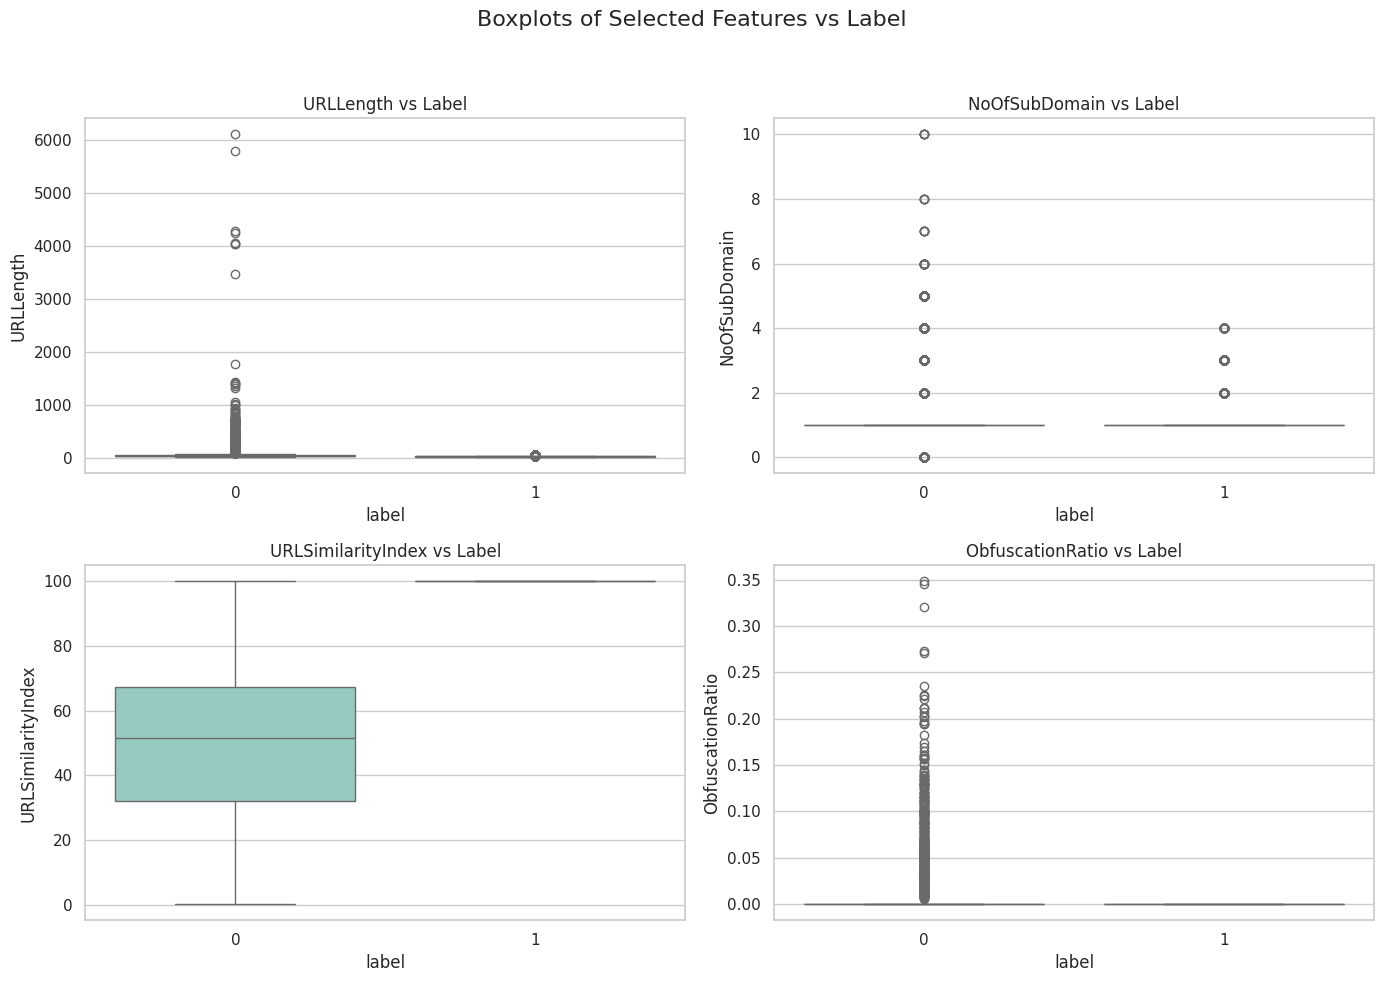

In [16]:
# Features to plot
features_to_plot = ['URLLength', 'NoOfSubDomain', 'URLSimilarityIndex', 'ObfuscationRatio']

# Create 2x2 subplots
fig, axes = plt.subplots(2, 2, figsize=(14, 10))  # Adjust size as needed
fig.suptitle('Boxplots of Selected Features vs Label', fontsize=16)

# Flatten axes array for easy iteration
axes = axes.flatten()

# Loop through features and plot
for i, col in enumerate(features_to_plot):
    sns.boxplot(x='label', y=col, data=df, palette='Set3', ax=axes[i])
    axes[i].set_title(f'{col} vs Label')

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

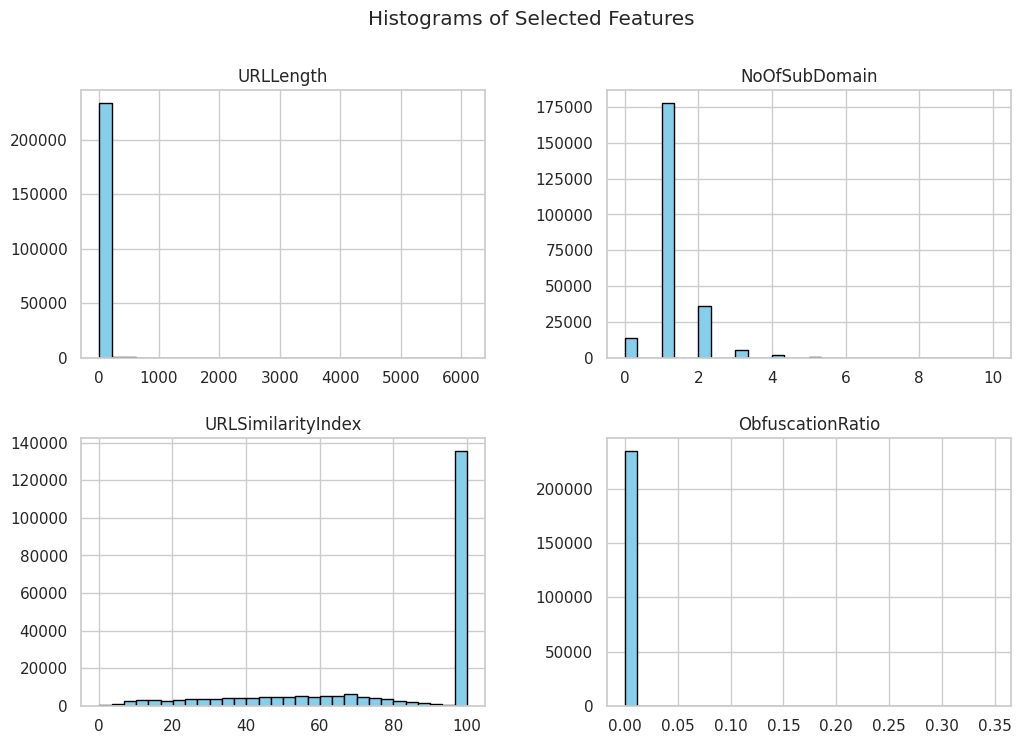

In [17]:
# Histogram of selected features
df[features_to_plot].hist(bins=30, figsize=(12, 8), color='skyblue', edgecolor='black')
plt.suptitle('Histograms of Selected Features')
plt.show()

What are the most common structural differences (e.g., length, domain format) between phishing and legitimate URLs?

In [18]:
from scipy import stats

# Set style for visualizations
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

In [19]:
# Separate phishing and legitimate URLs
phishing = df[df['label'] == 1]
legitimate = df[df['label'] == 0]

print(f"\nPhishing URLs: {len(phishing):,} ({len(phishing)/len(df)*100:.1f}%)")
print(f"Legitimate URLs: {len(legitimate):,} ({len(legitimate)/len(df)*100:.1f}%)")


Phishing URLs: 134,850 (57.3%)
Legitimate URLs: 100,520 (42.7%)


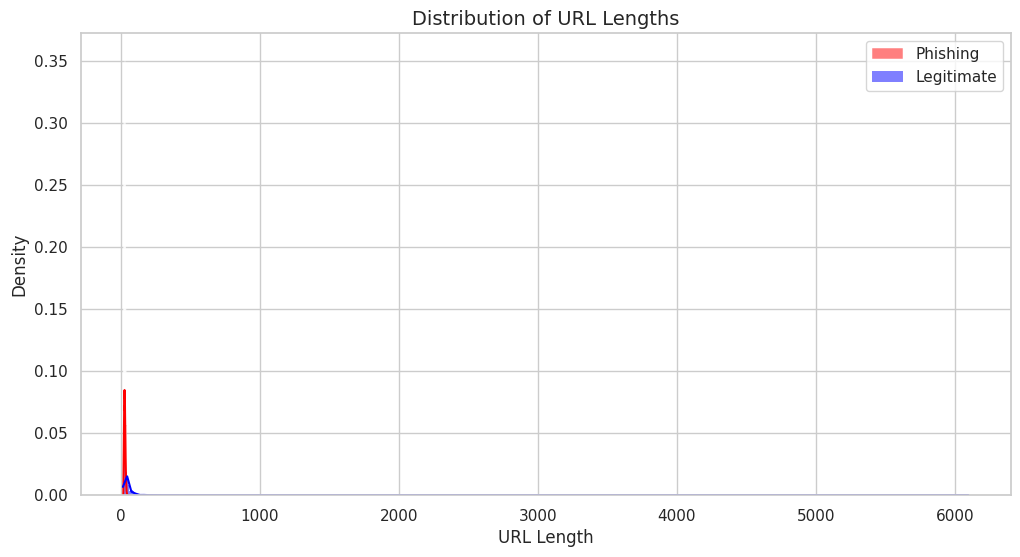


Statistical comparison for URLLength:
Phishing mean: 26.23
Legitimate mean: 45.70
Mann-Whitney U test p-value: 0.0000




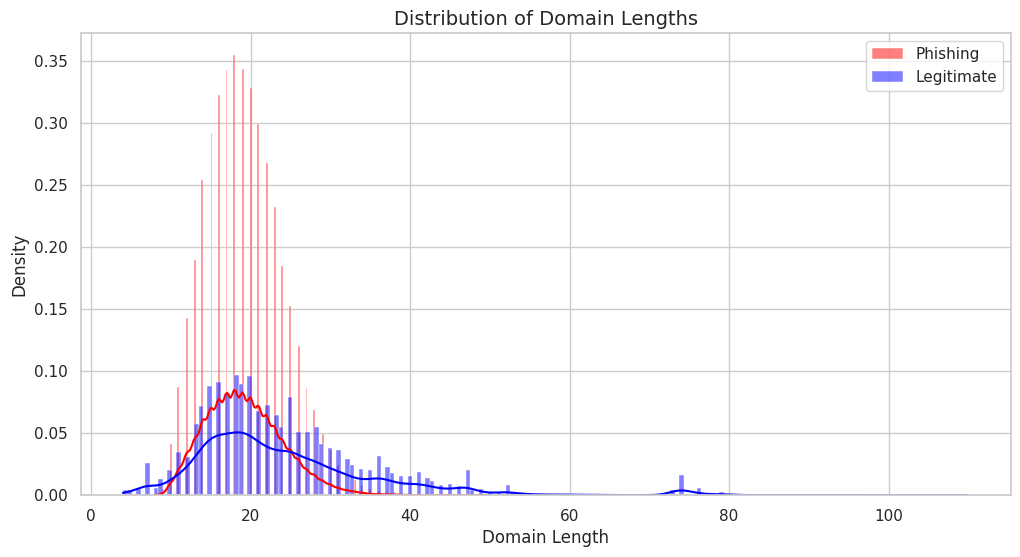


Statistical comparison for DomainLength:
Phishing mean: 19.23
Legitimate mean: 24.44
Mann-Whitney U test p-value: 0.0000




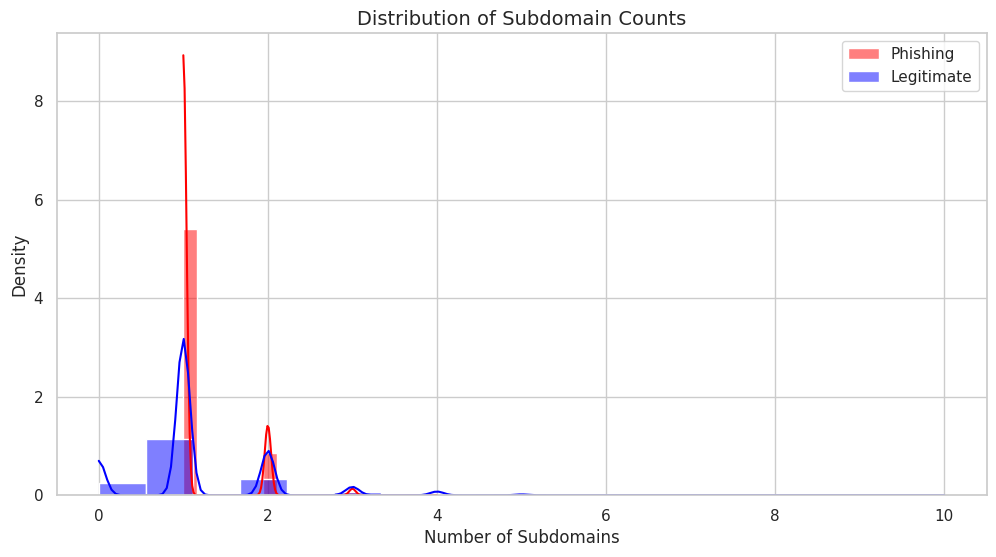


Statistical comparison for NoOfSubDomain:
Phishing mean: 1.16
Legitimate mean: 1.17
Mann-Whitney U test p-value: 0.0000




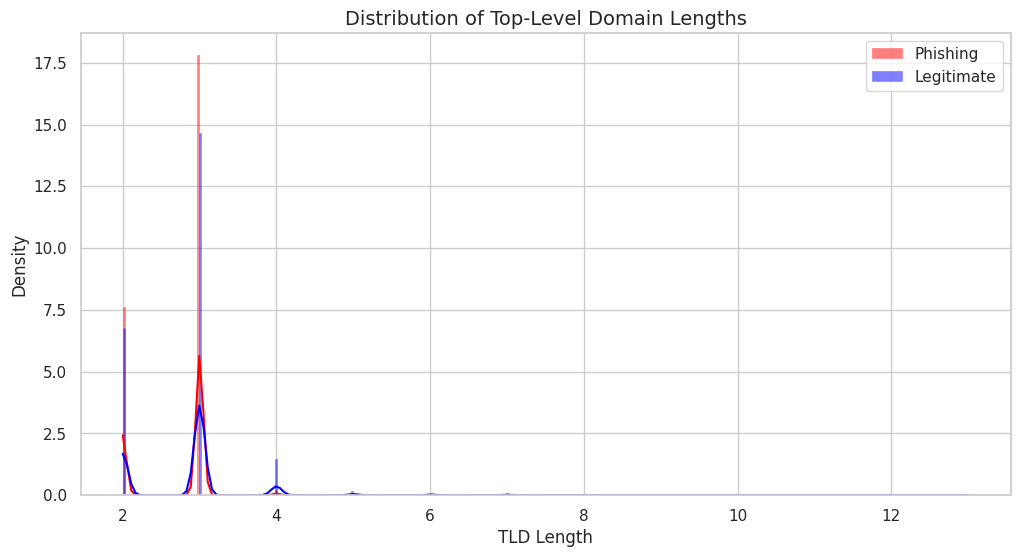


Statistical comparison for TLDLength:
Phishing mean: 2.72
Legitimate mean: 2.82
Mann-Whitney U test p-value: 0.0000




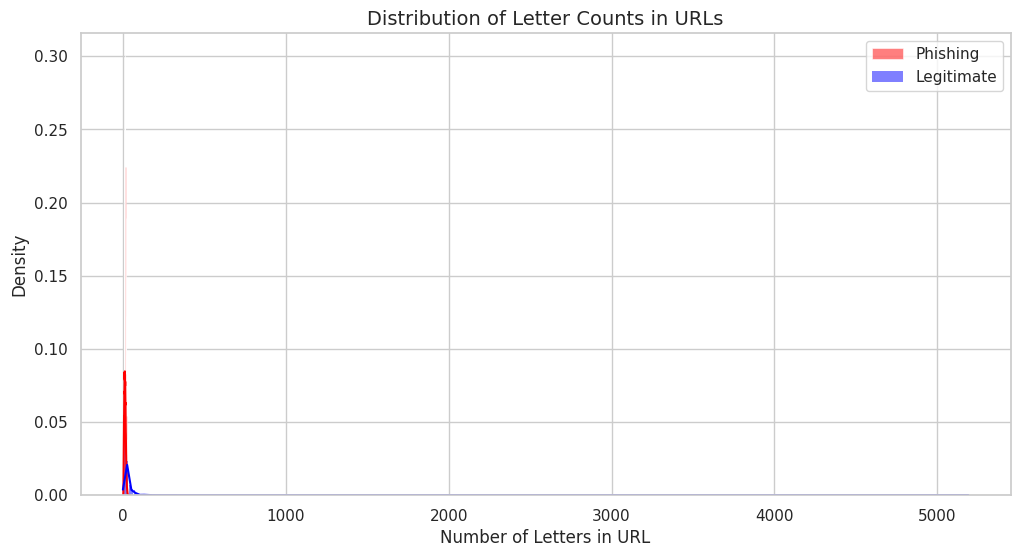


Statistical comparison for NoOfLettersInURL:
Phishing mean: 12.93
Legitimate mean: 28.09
Mann-Whitney U test p-value: 0.0000




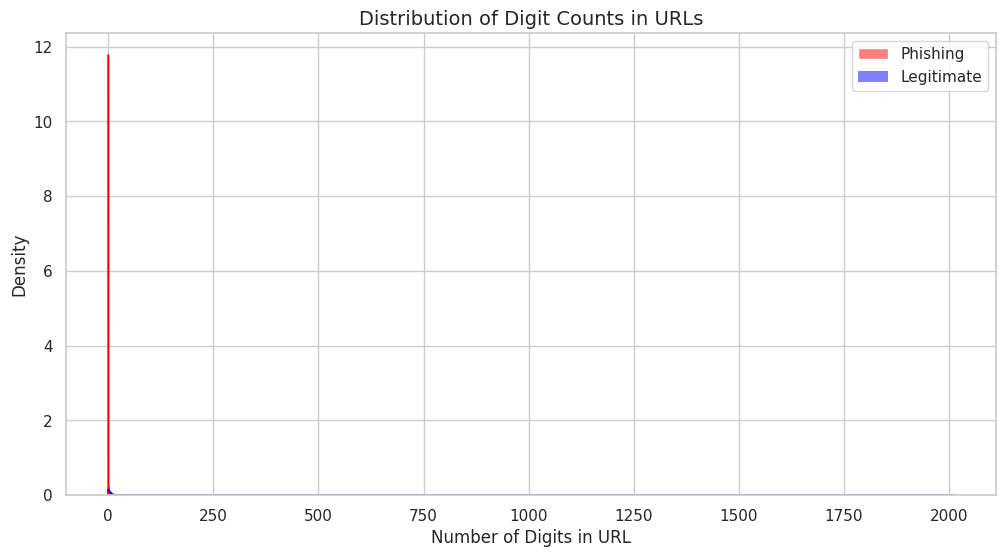


Statistical comparison for NoOfDegitsInURL:
Phishing mean: 0.05
Legitimate mean: 4.32
Mann-Whitney U test p-value: 0.0000




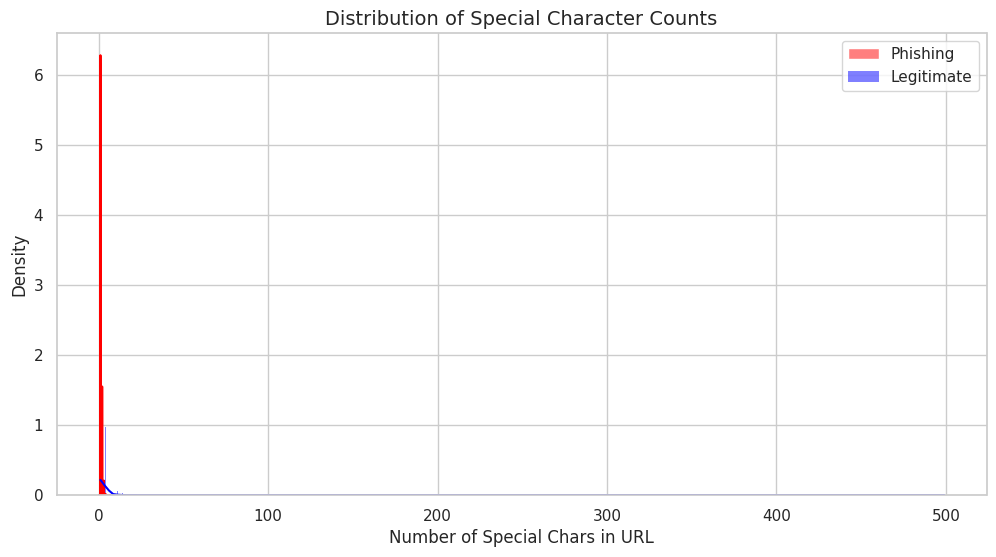


Statistical comparison for NoOfOtherSpecialCharsInURL:
Phishing mean: 1.24
Legitimate mean: 3.80
Mann-Whitney U test p-value: 0.0000




In [20]:
# Create a function to compare distributions
def compare_distributions(feature, xlabel, title, log_scale=False):
    plt.figure(figsize=(12, 6))

    # Plot histograms
    sns.histplot(phishing[feature], color='red', label='Phishing', kde=True, alpha=0.5, stat='density')
    sns.histplot(legitimate[feature], color='blue', label='Legitimate', kde=True, alpha=0.5, stat='density')

    plt.title(title, fontsize=14)
    plt.xlabel(xlabel, fontsize=12)
    plt.ylabel('Density', fontsize=12)
    plt.legend()

    if log_scale:
        plt.yscale('log')
        plt.title(f"{title} (Log Scale)")

    plt.show()

    # Statistical comparison
    print(f"\nStatistical comparison for {feature}:")
    print(f"Phishing mean: {phishing[feature].mean():.2f}")
    print(f"Legitimate mean: {legitimate[feature].mean():.2f}")
    print(f"Mann-Whitney U test p-value: {stats.mannwhitneyu(phishing[feature], legitimate[feature]).pvalue:.4f}")

# Compare key structural features
structural_features = [
    ('URLLength', 'URL Length', 'Distribution of URL Lengths'),
    ('DomainLength', 'Domain Length', 'Distribution of Domain Lengths'),
    ('NoOfSubDomain', 'Number of Subdomains', 'Distribution of Subdomain Counts'),
    ('TLDLength', 'TLD Length', 'Distribution of Top-Level Domain Lengths'),
    ('NoOfLettersInURL', 'Number of Letters in URL', 'Distribution of Letter Counts in URLs'),
    ('NoOfDegitsInURL', 'Number of Digits in URL', 'Distribution of Digit Counts in URLs'),
    ('NoOfOtherSpecialCharsInURL', 'Number of Special Chars in URL', 'Distribution of Special Character Counts')
]

for feature, xlabel, title in structural_features:
    compare_distributions(feature, xlabel, title)
    print("\n" + "="*80 + "\n")

How frequently do phishing URLs contain IP addresses instead of domain names?

<Figure size 1000x600 with 0 Axes>

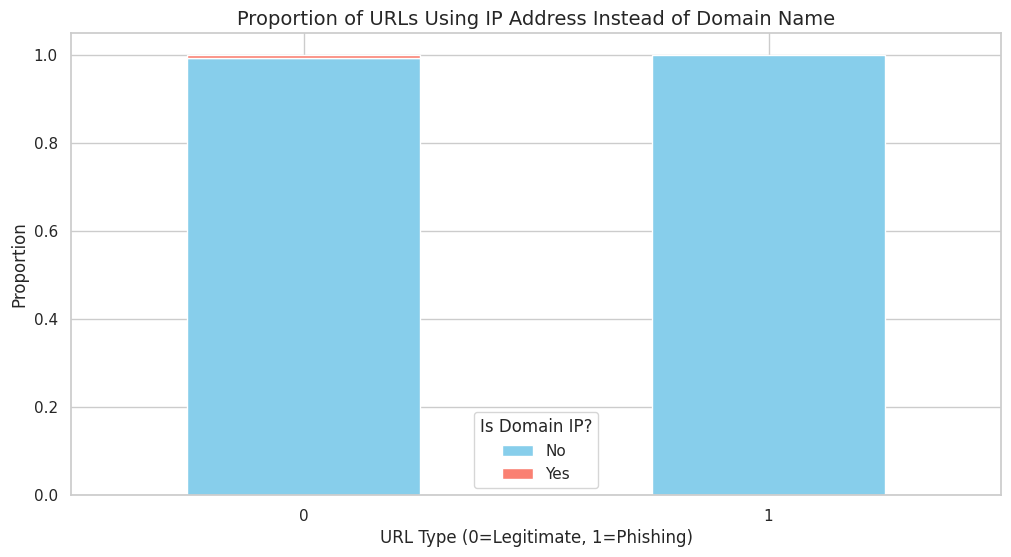


Count of URLs using IP addresses:
IsDomainIP       0    1
label                  
0            99884  636
1           134850    0

Proportion of URLs using IP addresses:
IsDomainIP         0         1
label                         
0           0.993673  0.006327
1           1.000000       NaN

Fisher's exact test p-value: 0.0000
Odds ratio: 0.0000


In [21]:
# 2. Frequency of IP Addresses in Phishing vs Legitimate URLs (Corrected Version)

# IP address frequency
ip_stats = df.groupby('label')['IsDomainIP'].value_counts(normalize=True).unstack()
ip_counts = df.groupby('label')['IsDomainIP'].value_counts().unstack()

# Ensure we have a proper 2x2 contingency table
# Fill any missing combinations with 0
ip_counts = ip_counts.fillna(0).astype(int)

plt.figure(figsize=(10, 6))
ip_stats.plot(kind='bar', stacked=True, color=['skyblue', 'salmon'])
plt.title('Proportion of URLs Using IP Address Instead of Domain Name', fontsize=14)
plt.xlabel('URL Type (0=Legitimate, 1=Phishing)', fontsize=12)
plt.ylabel('Proportion', fontsize=12)
plt.xticks(rotation=0)
plt.legend(title='Is Domain IP?', labels=['No', 'Yes'])
plt.show()

print("\nCount of URLs using IP addresses:")
print(ip_counts)
print("\nProportion of URLs using IP addresses:")
print(ip_stats)

# Perform Fisher's exact test only if we have a proper 2x2 table
if ip_counts.shape == (2, 2) and (ip_counts >= 0).all().all():
    try:
        oddsratio, pvalue = stats.fisher_exact(ip_counts)
        print(f"\nFisher's exact test p-value: {pvalue:.4f}")
        print(f"Odds ratio: {oddsratio:.4f}")
    except ValueError as e:
        print(f"\nCould not perform Fisher's exact test: {e}")
else:
    print("\nContingency table is not 2x2 or contains negative values - cannot perform Fisher's exact test")
    print("Using chi-square test instead:")
    chi2, p, dof, expected = stats.chi2_contingency(ip_counts)
    print(f"Chi-square test p-value: {p:.4f}")

What is the distribution of URL lengths across phishing versus legitimate entries?

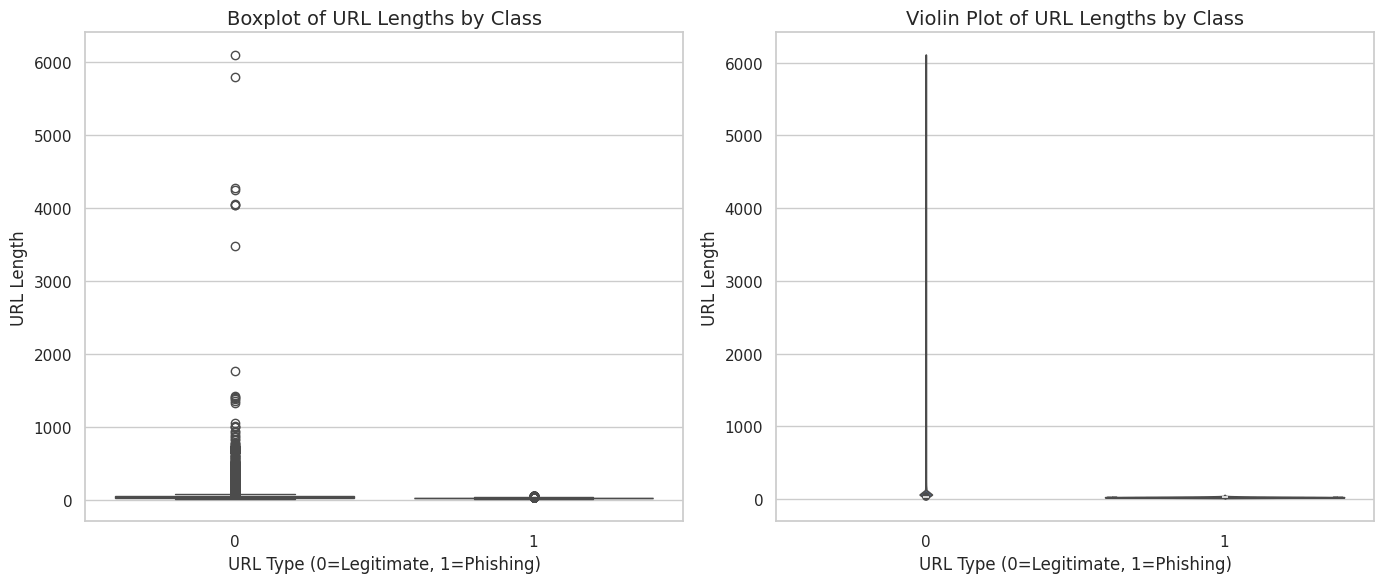


URL Length Statistics:
          count       mean        std   min   25%   50%   75%     max
label                                                                
0      100520.0  45.702845  61.252568  13.0  26.0  34.0  48.0  6097.0
1      134850.0  26.228610   4.815612  15.0  23.0  26.0  29.0    57.0


In [22]:
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
sns.boxplot(x='label', y='URLLength', data=df)
plt.title('Boxplot of URL Lengths by Class', fontsize=14)
plt.xlabel('URL Type (0=Legitimate, 1=Phishing)', fontsize=12)
plt.ylabel('URL Length', fontsize=12)

plt.subplot(1, 2, 2)
sns.violinplot(x='label', y='URLLength', data=df)
plt.title('Violin Plot of URL Lengths by Class', fontsize=14)
plt.xlabel('URL Type (0=Legitimate, 1=Phishing)', fontsize=12)
plt.ylabel('URL Length', fontsize=12)

plt.tight_layout()
plt.show()

# Statistical summary
print("\nURL Length Statistics:")
print(df.groupby('label')['URLLength'].describe())


How does the use of HTTPS differ between phishing and legitimate websites?

<Figure size 1000x600 with 0 Axes>

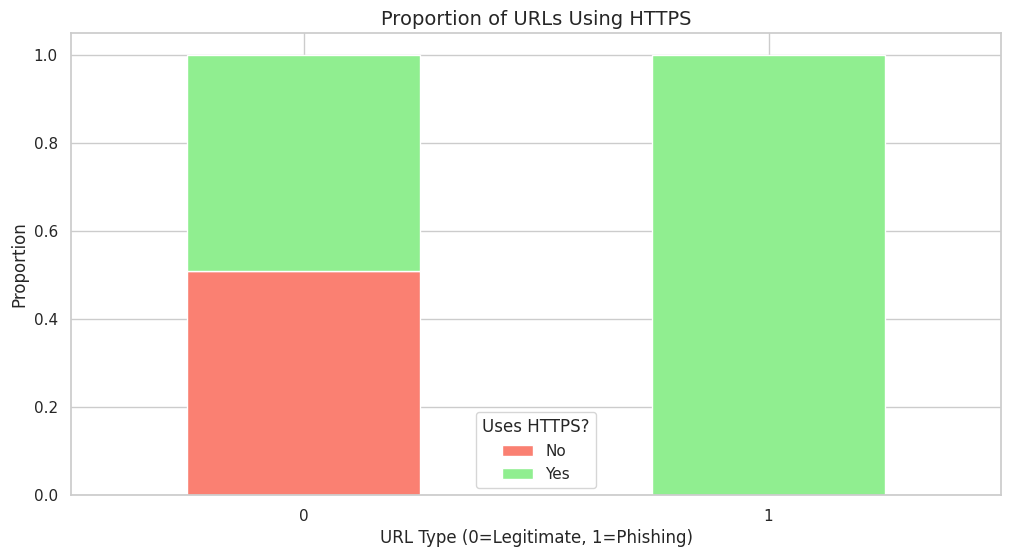


Count of HTTPS usage:
IsHTTPS        0         1
label                     
0        51142.0   49378.0
1            NaN  134850.0

Proportion of HTTPS usage:
IsHTTPS         0         1
label                      
0        0.508774  0.491226
1             NaN  1.000000

Chi-square test p-value: nan


In [23]:
https_stats = df.groupby('label')['IsHTTPS'].value_counts(normalize=True).unstack()
https_counts = df.groupby('label')['IsHTTPS'].value_counts().unstack()

plt.figure(figsize=(10, 6))
https_stats.plot(kind='bar', stacked=True, color=['salmon', 'lightgreen'])
plt.title('Proportion of URLs Using HTTPS', fontsize=14)
plt.xlabel('URL Type (0=Legitimate, 1=Phishing)', fontsize=12)
plt.ylabel('Proportion', fontsize=12)
plt.xticks(rotation=0)
plt.legend(title='Uses HTTPS?', labels=['No', 'Yes'])
plt.show()

print("\nCount of HTTPS usage:")
print(https_counts)
print("\nProportion of HTTPS usage:")
print(https_stats)
print(f"\nChi-square test p-value: {stats.chi2_contingency(https_counts)[1]:.4f}")

What is the frequency and distribution of special characters in phishing URLs compared to legitimate ones?

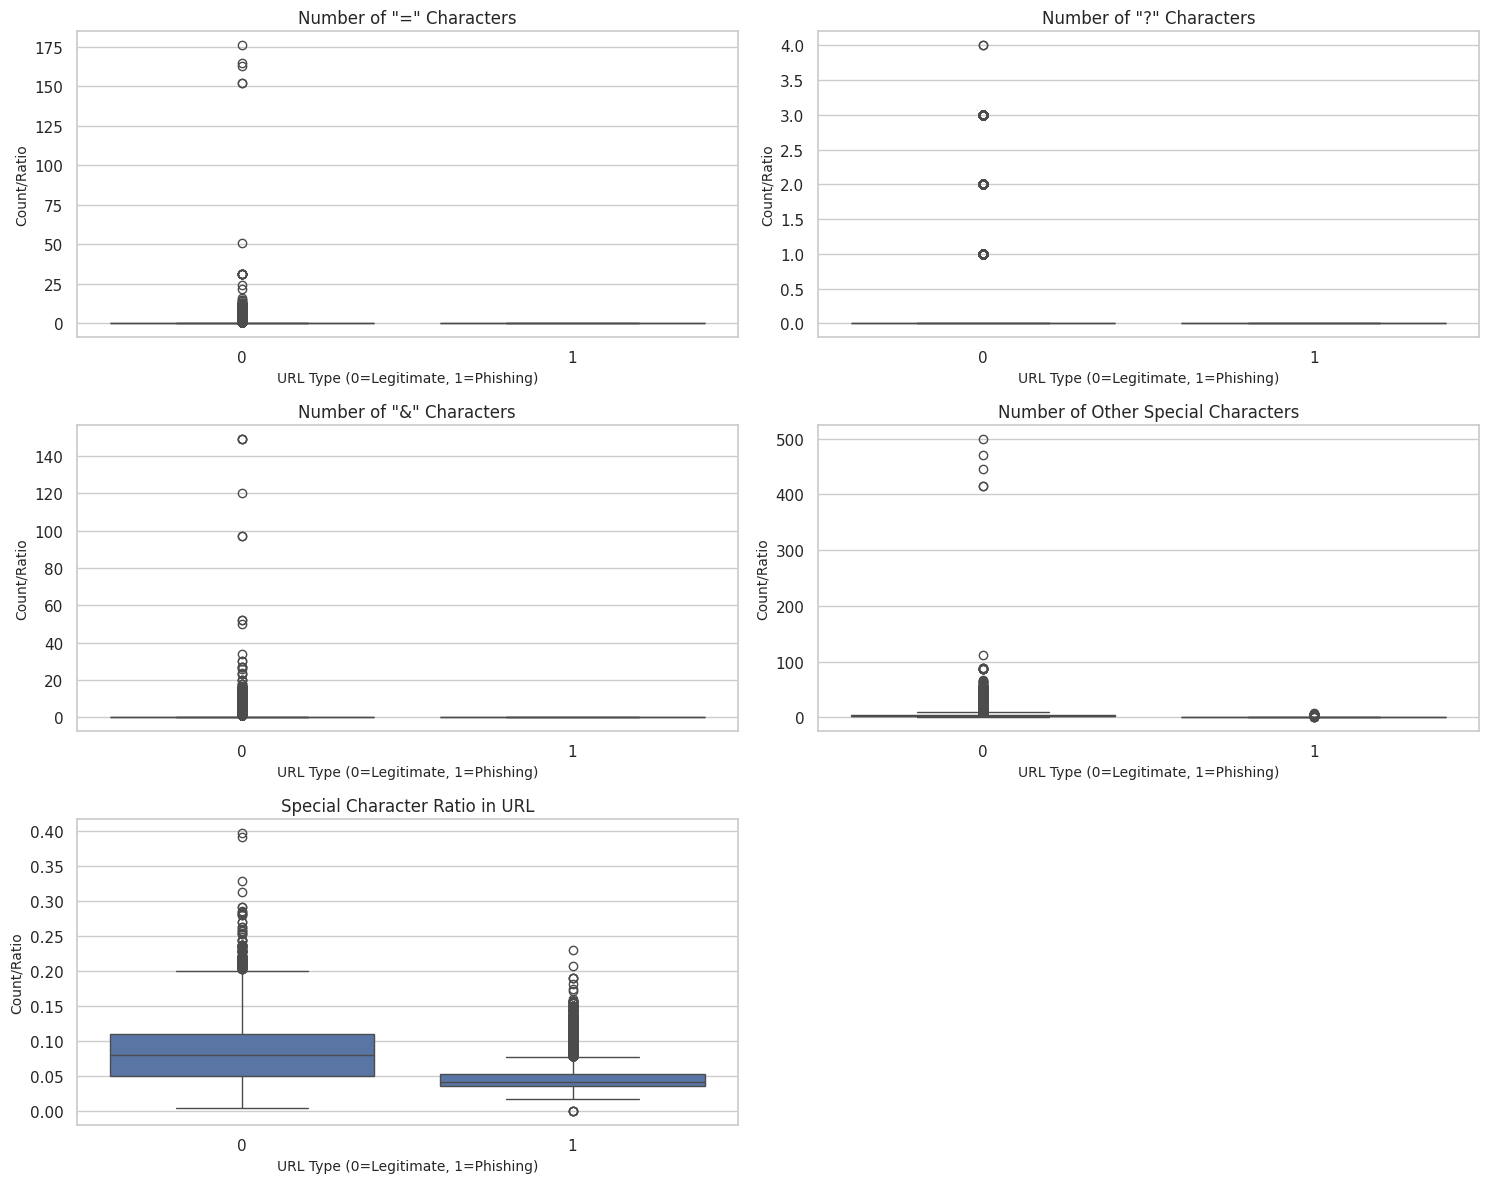


Special Character Statistics:

Number of "=" Characters:
Phishing mean: 0.00
Legitimate mean: 0.15
Mann-Whitney U test p-value: 0.0000

Number of "?" Characters:
Phishing mean: 0.00
Legitimate mean: 0.07
Mann-Whitney U test p-value: 0.0000

Number of "&" Characters:
Phishing mean: 0.00
Legitimate mean: 0.06
Mann-Whitney U test p-value: 0.0000

Number of Other Special Characters:
Phishing mean: 1.24
Legitimate mean: 3.80
Mann-Whitney U test p-value: 0.0000

Special Character Ratio in URL:
Phishing mean: 0.05
Legitimate mean: 0.08
Mann-Whitney U test p-value: 0.0000


In [24]:
special_char_features = [
    ('NoOfEqualsInURL', 'Number of "=" Characters'),
    ('NoOfQMarkInURL', 'Number of "?" Characters'),
    ('NoOfAmpersandInURL', 'Number of "&" Characters'),
    ('NoOfOtherSpecialCharsInURL', 'Number of Other Special Characters'),
    ('SpacialCharRatioInURL', 'Special Character Ratio in URL')
]

plt.figure(figsize=(15, 12))
for i, (feature, title) in enumerate(special_char_features, 1):
    plt.subplot(3, 2, i)
    sns.boxplot(x='label', y=feature, data=df)
    plt.title(title, fontsize=12)
    plt.xlabel('URL Type (0=Legitimate, 1=Phishing)', fontsize=10)
    plt.ylabel('Count/Ratio', fontsize=10)

plt.tight_layout()
plt.show()

# Statistical comparison
print("\nSpecial Character Statistics:")
for feature, title in special_char_features:
    print(f"\n{title}:")
    print(f"Phishing mean: {phishing[feature].mean():.2f}")
    print(f"Legitimate mean: {legitimate[feature].mean():.2f}")
    print(f"Mann-Whitney U test p-value: {stats.mannwhitneyu(phishing[feature], legitimate[feature]).pvalue:.4f}")

Do phishing URLs tend to have more subdomains or longer domain chains than legitimate ones?

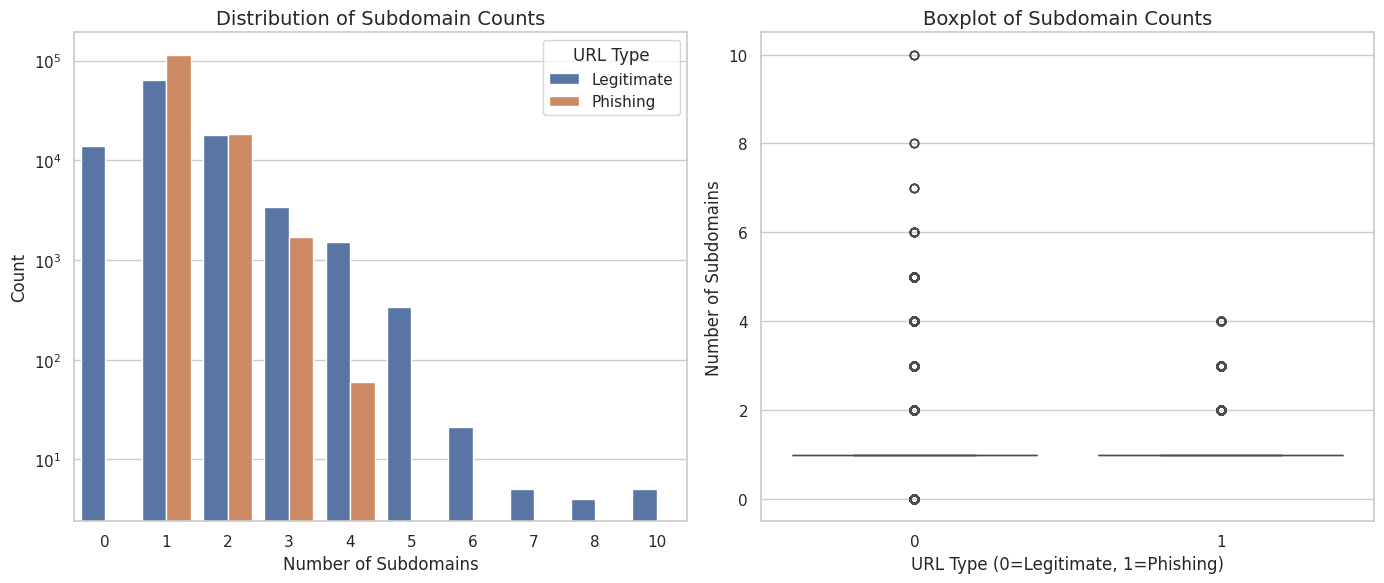


Subdomain Count Statistics:
          count      mean       std  min  25%  50%  75%   max
label                                                        
0      100520.0  1.169379  0.791096  0.0  1.0  1.0  1.0  10.0
1      134850.0  1.161661  0.404076  1.0  1.0  1.0  1.0   4.0

Mann-Whitney U test p-value: 0.0000


In [25]:
plt.figure(figsize=(14, 6))

# Subdomain count
plt.subplot(1, 2, 1)
sns.countplot(x='NoOfSubDomain', hue='label', data=df)
plt.title('Distribution of Subdomain Counts', fontsize=14)
plt.xlabel('Number of Subdomains', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.yscale('log')
plt.legend(title='URL Type', labels=['Legitimate', 'Phishing'])

# Subdomain count statistics
plt.subplot(1, 2, 2)
sns.boxplot(x='label', y='NoOfSubDomain', data=df)
plt.title('Boxplot of Subdomain Counts', fontsize=14)
plt.xlabel('URL Type (0=Legitimate, 1=Phishing)', fontsize=12)
plt.ylabel('Number of Subdomains', fontsize=12)

plt.tight_layout()
plt.show()

print("\nSubdomain Count Statistics:")
print(df.groupby('label')['NoOfSubDomain'].describe())
print(f"\nMann-Whitney U test p-value: {stats.mannwhitneyu(phishing['NoOfSubDomain'], legitimate['NoOfSubDomain']).pvalue:.4f}")

How do obfuscation indicators (e.g., encoding, excessive characters, hidden elements) appear across phishing and legitimate URLs?

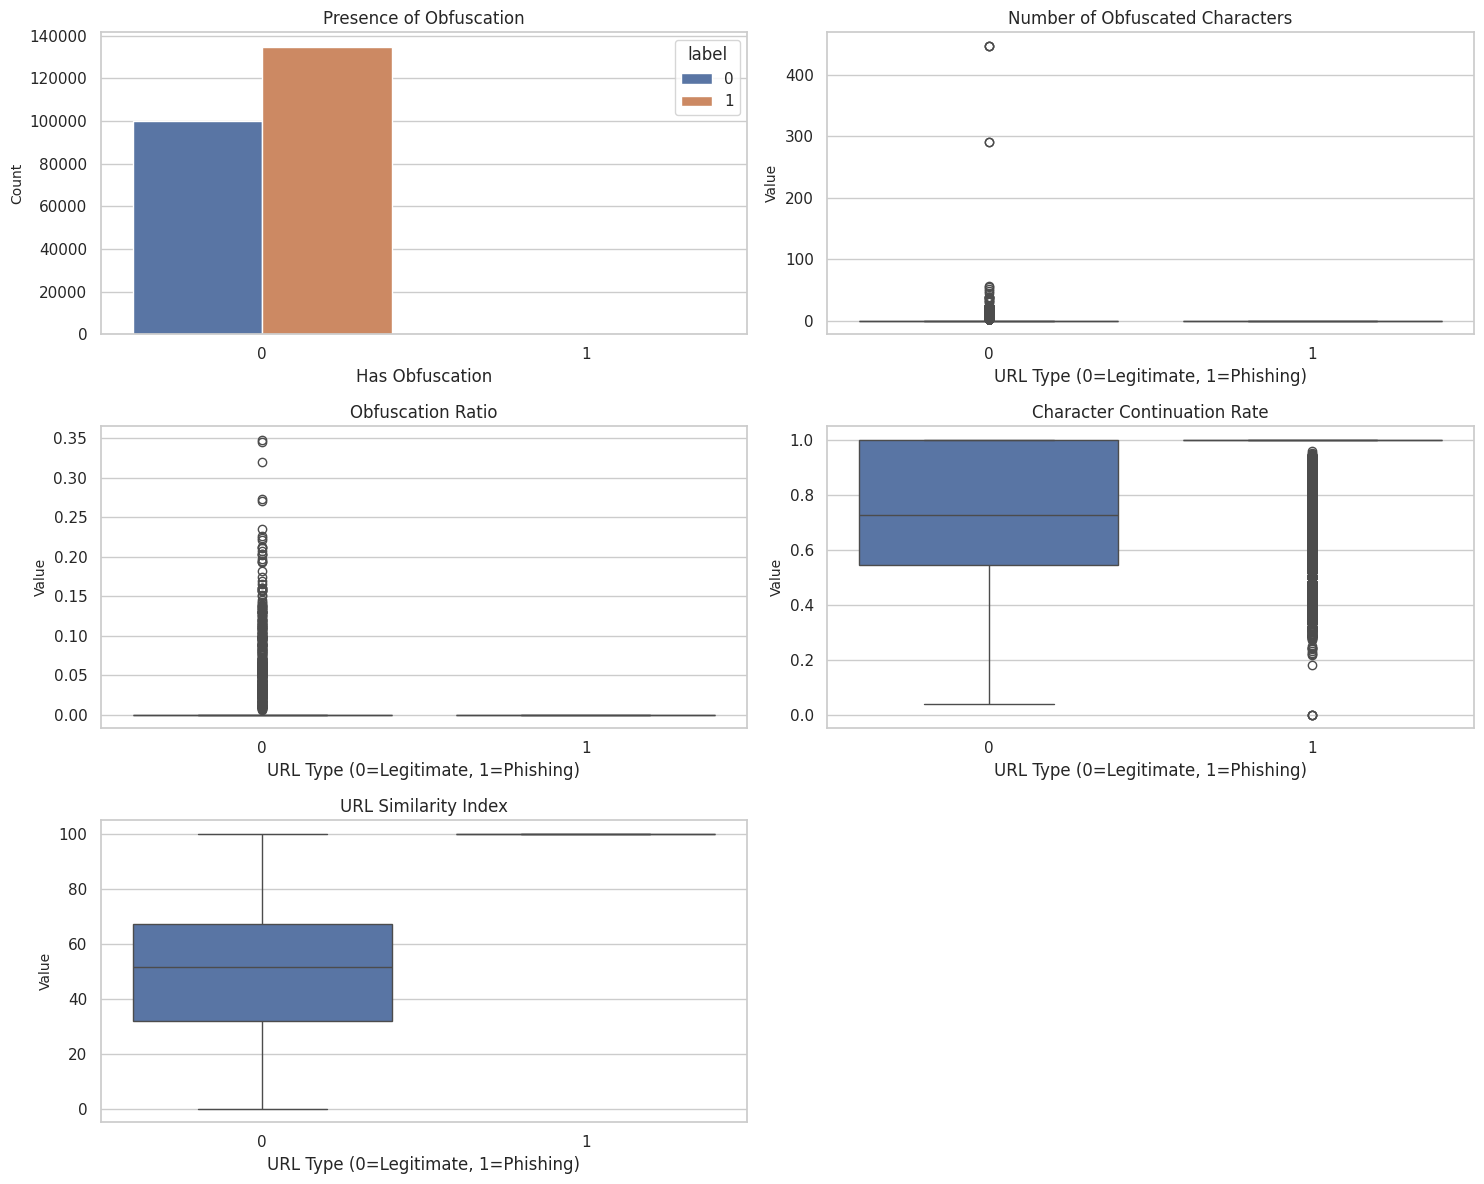


Obfuscation Statistics:

Presence of Obfuscation:
HasObfuscation       0    1
label                      
0               100037  483
1               134850    0
Chi-square test p-value: 0.0000

Number of Obfuscated Characters:
Phishing mean: 0.00
Legitimate mean: 0.06
Mann-Whitney U test p-value: 0.0000

Obfuscation Ratio:
Phishing mean: 0.00
Legitimate mean: 0.00
Mann-Whitney U test p-value: 0.0000

Character Continuation Rate:
Phishing mean: 0.93
Legitimate mean: 0.73
Mann-Whitney U test p-value: 0.0000

URL Similarity Index:
Phishing mean: 100.00
Legitimate mean: 49.65
Mann-Whitney U test p-value: 0.0000


In [26]:
obfuscation_features = [
    ('HasObfuscation', 'Presence of Obfuscation'),
    ('NoOfObfuscatedChar', 'Number of Obfuscated Characters'),
    ('ObfuscationRatio', 'Obfuscation Ratio'),
    ('CharContinuationRate', 'Character Continuation Rate'),
    ('URLSimilarityIndex', 'URL Similarity Index')
]

plt.figure(figsize=(15, 12))
for i, (feature, title) in enumerate(obfuscation_features, 1):
    plt.subplot(3, 2, i)
    if feature == 'HasObfuscation':
        sns.countplot(x=feature, hue='label', data=df)
    else:
        sns.boxplot(x='label', y=feature, data=df)
    plt.title(title, fontsize=12)
    plt.xlabel('URL Type (0=Legitimate, 1=Phishing)' if feature != 'HasObfuscation' else 'Has Obfuscation')
    plt.ylabel('Count' if feature == 'HasObfuscation' else 'Value', fontsize=10)

plt.tight_layout()
plt.show()

# Statistical comparison
print("\nObfuscation Statistics:")
for feature, title in obfuscation_features:
    print(f"\n{title}:")
    if feature != 'HasObfuscation':
        print(f"Phishing mean: {phishing[feature].mean():.2f}")
        print(f"Legitimate mean: {legitimate[feature].mean():.2f}")
        print(f"Mann-Whitney U test p-value: {stats.mannwhitneyu(phishing[feature], legitimate[feature]).pvalue:.4f}")
    else:
        obs = pd.crosstab(df['label'], df[feature])
        print(obs)
        print(f"Chi-square test p-value: {stats.chi2_contingency(obs)[1]:.4f}")

What is the distribution of phishing attempts across targeted sectors (e.g., banking, crypto, payment) based on keywords and title matching?

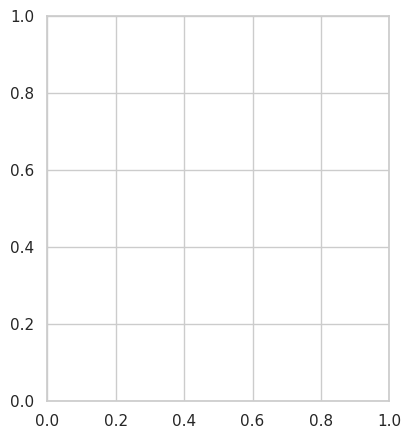

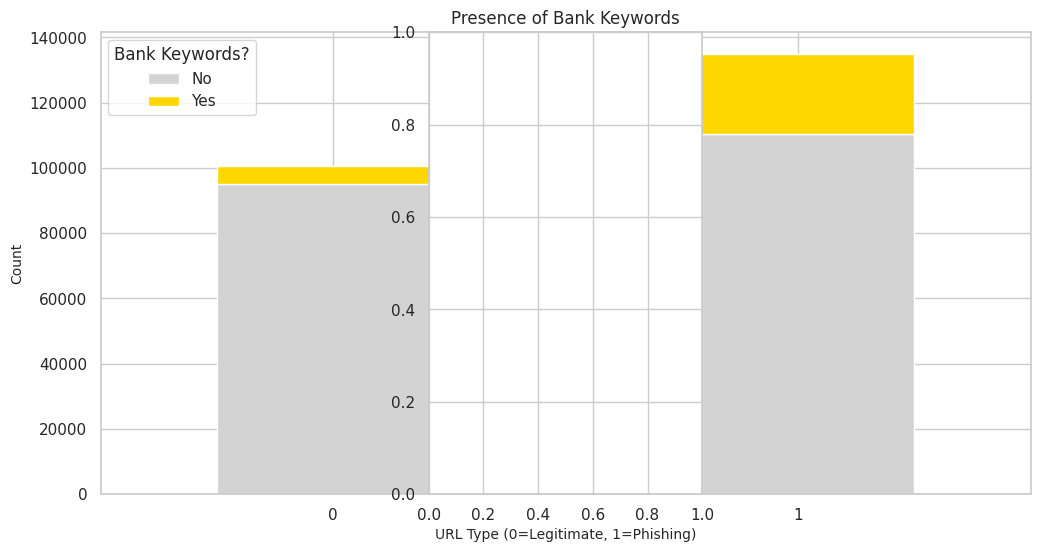

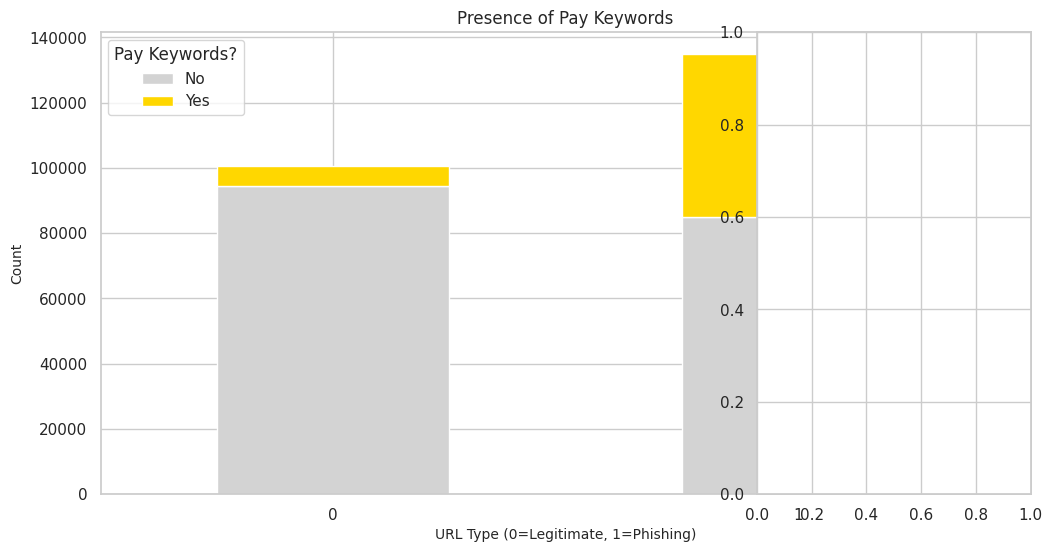

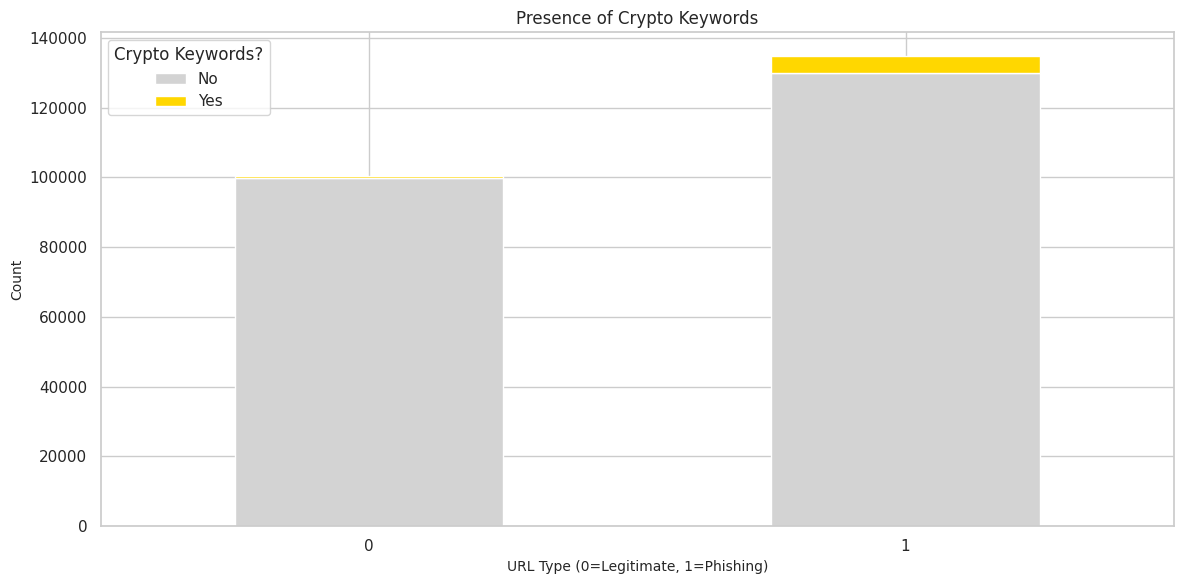


Targeted Sector Statistics:

Bank Keywords:
Bank        0      1
label               
0       95061   5459
1      110369  24481
Fisher's exact test p-value: 0.0000

Pay Keywords:
Pay        0      1
label              
0      94488   6032
1      85041  49809
Fisher's exact test p-value: 0.0000

Crypto Keywords:
Crypto       0     1
label               
0        99916   604
1       129925  4925
Fisher's exact test p-value: 0.0000


In [27]:
sector_features = ['Bank', 'Pay', 'Crypto']

plt.figure(figsize=(15, 5))
for i, feature in enumerate(sector_features, 1):
    plt.subplot(1, 3, i)
    sector_counts = df.groupby('label')[feature].value_counts().unstack()
    sector_counts.plot(kind='bar', stacked=True, color=['lightgray', 'gold'])
    plt.title(f'Presence of {feature} Keywords', fontsize=12)
    plt.xlabel('URL Type (0=Legitimate, 1=Phishing)', fontsize=10)
    plt.ylabel('Count', fontsize=10)
    plt.legend(title=f'{feature} Keywords?', labels=['No', 'Yes'])
    plt.xticks(rotation=0)

plt.tight_layout()
plt.show()

# Statistical analysis
print("\nTargeted Sector Statistics:")
for feature in sector_features:
    print(f"\n{feature} Keywords:")
    obs = pd.crosstab(df['label'], df[feature])
    print(obs)
    print(f"Fisher's exact test p-value: {stats.fisher_exact(obs)[1]:.4f}")

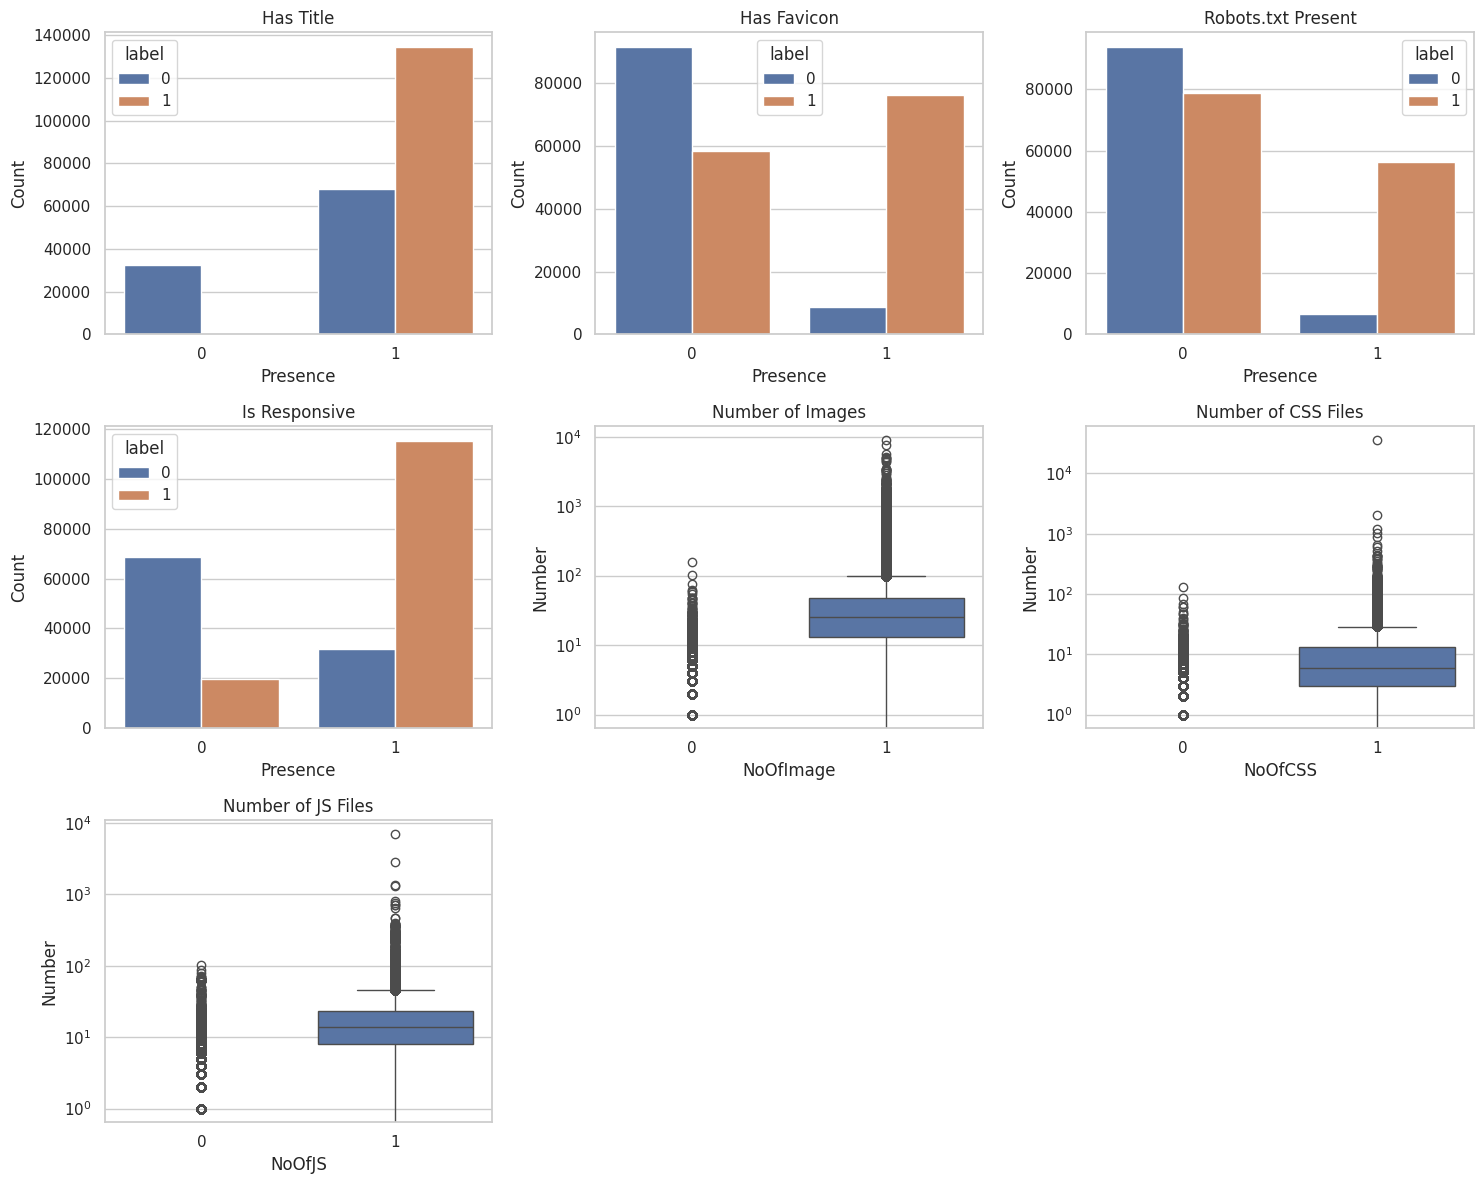


Website Content Statistics:

Has Title:
HasTitle      0       1
label                  
0         32444   68076
1           168  134682
Chi-square test p-value: 0.0000

Has Favicon:
HasFavicon      0      1
label                   
0           91734   8786
1           58387  76463
Chi-square test p-value: 0.0000

Robots.txt Present:
Robots      0      1
label               
0       93906   6614
1       78653  56197
Chi-square test p-value: 0.0000

Is Responsive:
IsResponsive      0       1
label                      
0             68651   31869
1             19639  115211
Chi-square test p-value: 0.0000

Number of Images:
Phishing mean: 44.95
Legitimate mean: 0.86
Mann-Whitney U test p-value: 0.0000

Number of CSS Files:
Phishing mean: 10.74
Legitimate mean: 0.44
Mann-Whitney U test p-value: 0.0000

Number of JS Files:
Phishing mean: 17.73
Legitimate mean: 0.89
Mann-Whitney U test p-value: 0.0000


In [28]:
content_features = [
    ('HasTitle', 'Has Title'),
    ('HasFavicon', 'Has Favicon'),
    ('Robots', 'Robots.txt Present'),
    ('IsResponsive', 'Is Responsive'),
    ('NoOfImage', 'Number of Images'),
    ('NoOfCSS', 'Number of CSS Files'),
    ('NoOfJS', 'Number of JS Files')
]

plt.figure(figsize=(15, 12))
for i, (feature, title) in enumerate(content_features, 1):
    plt.subplot(3, 3, i)
    if feature in ['NoOfImage', 'NoOfCSS', 'NoOfJS']:
        sns.boxplot(x='label', y=feature, data=df)
        plt.yscale('log')
    else:
        sns.countplot(x=feature, hue='label', data=df)
    plt.title(title, fontsize=12)
    plt.xlabel(feature if feature in ['NoOfImage', 'NoOfCSS', 'NoOfJS'] else 'Presence')
    plt.ylabel('Count' if feature not in ['NoOfImage', 'NoOfCSS', 'NoOfJS'] else 'Number')

plt.tight_layout()
plt.show()

# Statistical analysis
print("\nWebsite Content Statistics:")
for feature, title in content_features:
    print(f"\n{title}:")
    if feature in ['NoOfImage', 'NoOfCSS', 'NoOfJS']:
        print(f"Phishing mean: {phishing[feature].mean():.2f}")
        print(f"Legitimate mean: {legitimate[feature].mean():.2f}")
        print(f"Mann-Whitney U test p-value: {stats.mannwhitneyu(phishing[feature], legitimate[feature]).pvalue:.4f}")
    else:
        obs = pd.crosstab(df['label'], df[feature])
        print(obs)
        print(f"Chi-square test p-value: {stats.chi2_contingency(obs)[1]:.4f}")

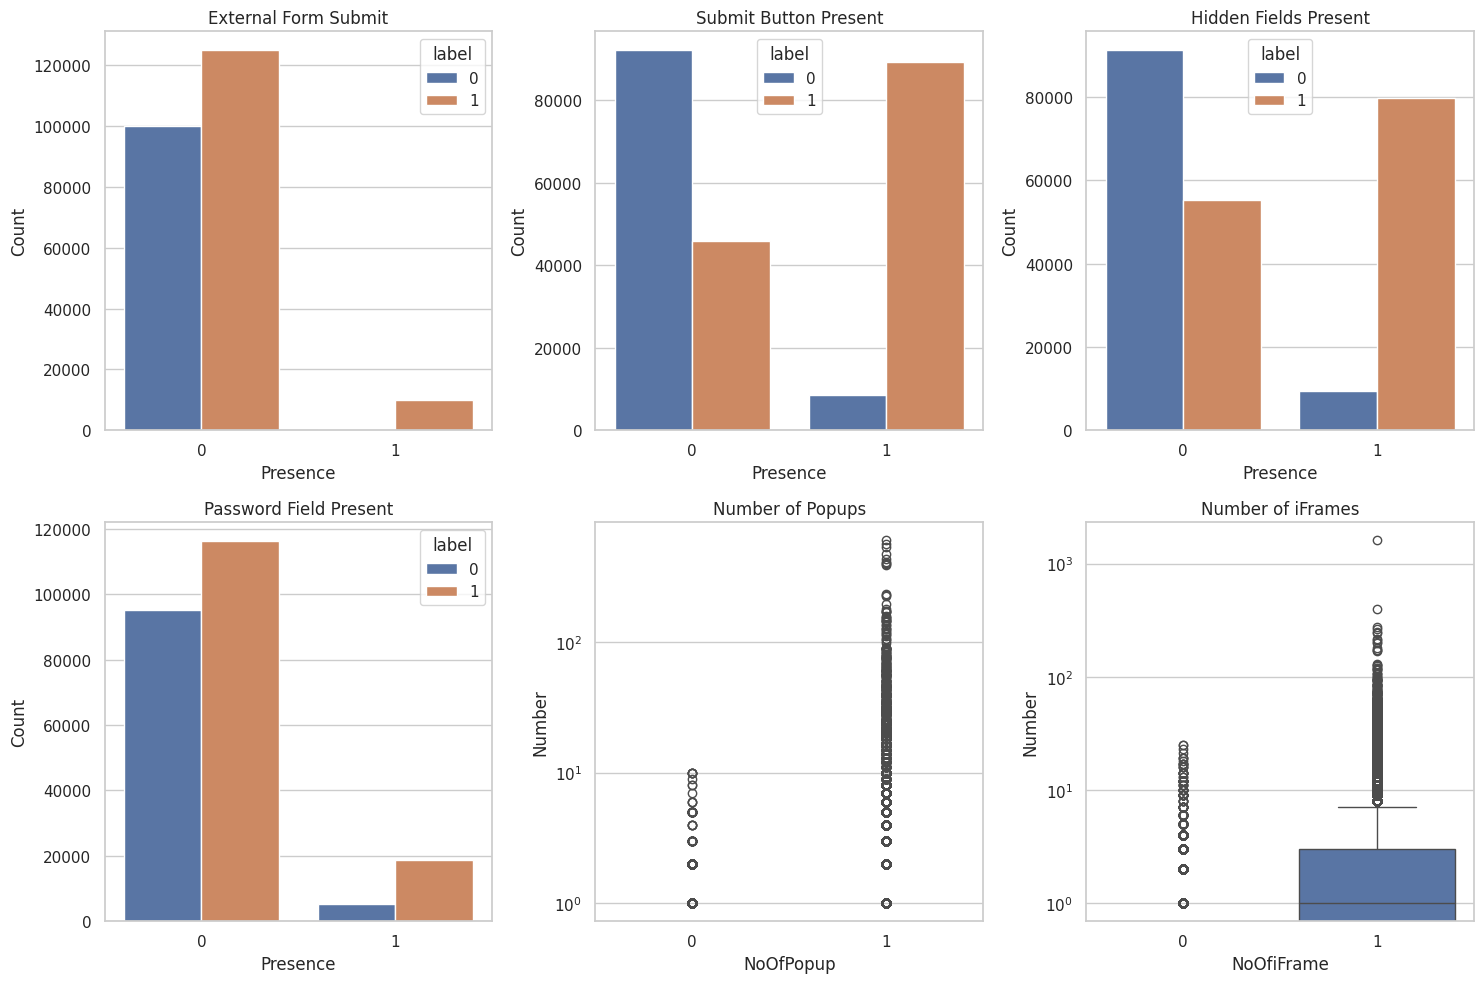


Form and Security Statistics:

External Form Submit:
HasExternalFormSubmit       0     1
label                              
0                      100091   429
1                      124909  9941
Chi-square test p-value: 0.0000

Submit Button Present:
HasSubmitButton      0      1
label                        
0                92037   8483
1                45730  89120
Chi-square test p-value: 0.0000

Hidden Fields Present:
HasHiddenFields      0      1
label                        
0                91168   9352
1                55183  79667
Chi-square test p-value: 0.0000

Password Field Present:
HasPasswordField       0      1
label                          
0                  95162   5358
1                 116175  18675
Chi-square test p-value: 0.0000

Number of Popups:
Phishing mean: 0.38
Legitimate mean: 0.01
Mann-Whitney U test p-value: 0.0000

Number of iFrames:
Phishing mean: 2.71
Legitimate mean: 0.08
Mann-Whitney U test p-value: 0.0000


In [30]:
security_features = [
    ('HasExternalFormSubmit', 'External Form Submit'),
    ('HasSubmitButton', 'Submit Button Present'),
    ('HasHiddenFields', 'Hidden Fields Present'),
    ('HasPasswordField', 'Password Field Present'),
    ('NoOfPopup', 'Number of Popups'),
    ('NoOfiFrame', 'Number of iFrames')
]

plt.figure(figsize=(15, 10))
for i, (feature, title) in enumerate(security_features, 1):
    plt.subplot(2, 3, i)
    if feature in ['NoOfPopup', 'NoOfiFrame']:
        sns.boxplot(x='label', y=feature, data=df)
        plt.yscale('log')
    else:
        sns.countplot(x=feature, hue='label', data=df)
    plt.title(title, fontsize=12)
    plt.xlabel(feature if feature in ['NoOfPopup', 'NoOfiFrame'] else 'Presence')
    plt.ylabel('Count' if feature not in ['NoOfPopup', 'NoOfiFrame'] else 'Number')

plt.tight_layout()
plt.show()

# Statistical analysis
print("\nForm and Security Statistics:")
for feature, title in security_features:
    print(f"\n{title}:")
    if feature in ['NoOfPopup', 'NoOfiFrame']:
        print(f"Phishing mean: {phishing[feature].mean():.2f}")
        print(f"Legitimate mean: {legitimate[feature].mean():.2f}")
        print(f"Mann-Whitney U test p-value: {stats.mannwhitneyu(phishing[feature], legitimate[feature]).pvalue:.4f}")
    else:
        obs = pd.crosstab(df['label'], df[feature])
        print(obs)
        print(f"Chi-square test p-value: {stats.chi2_contingency(obs)[1]:.4f}")

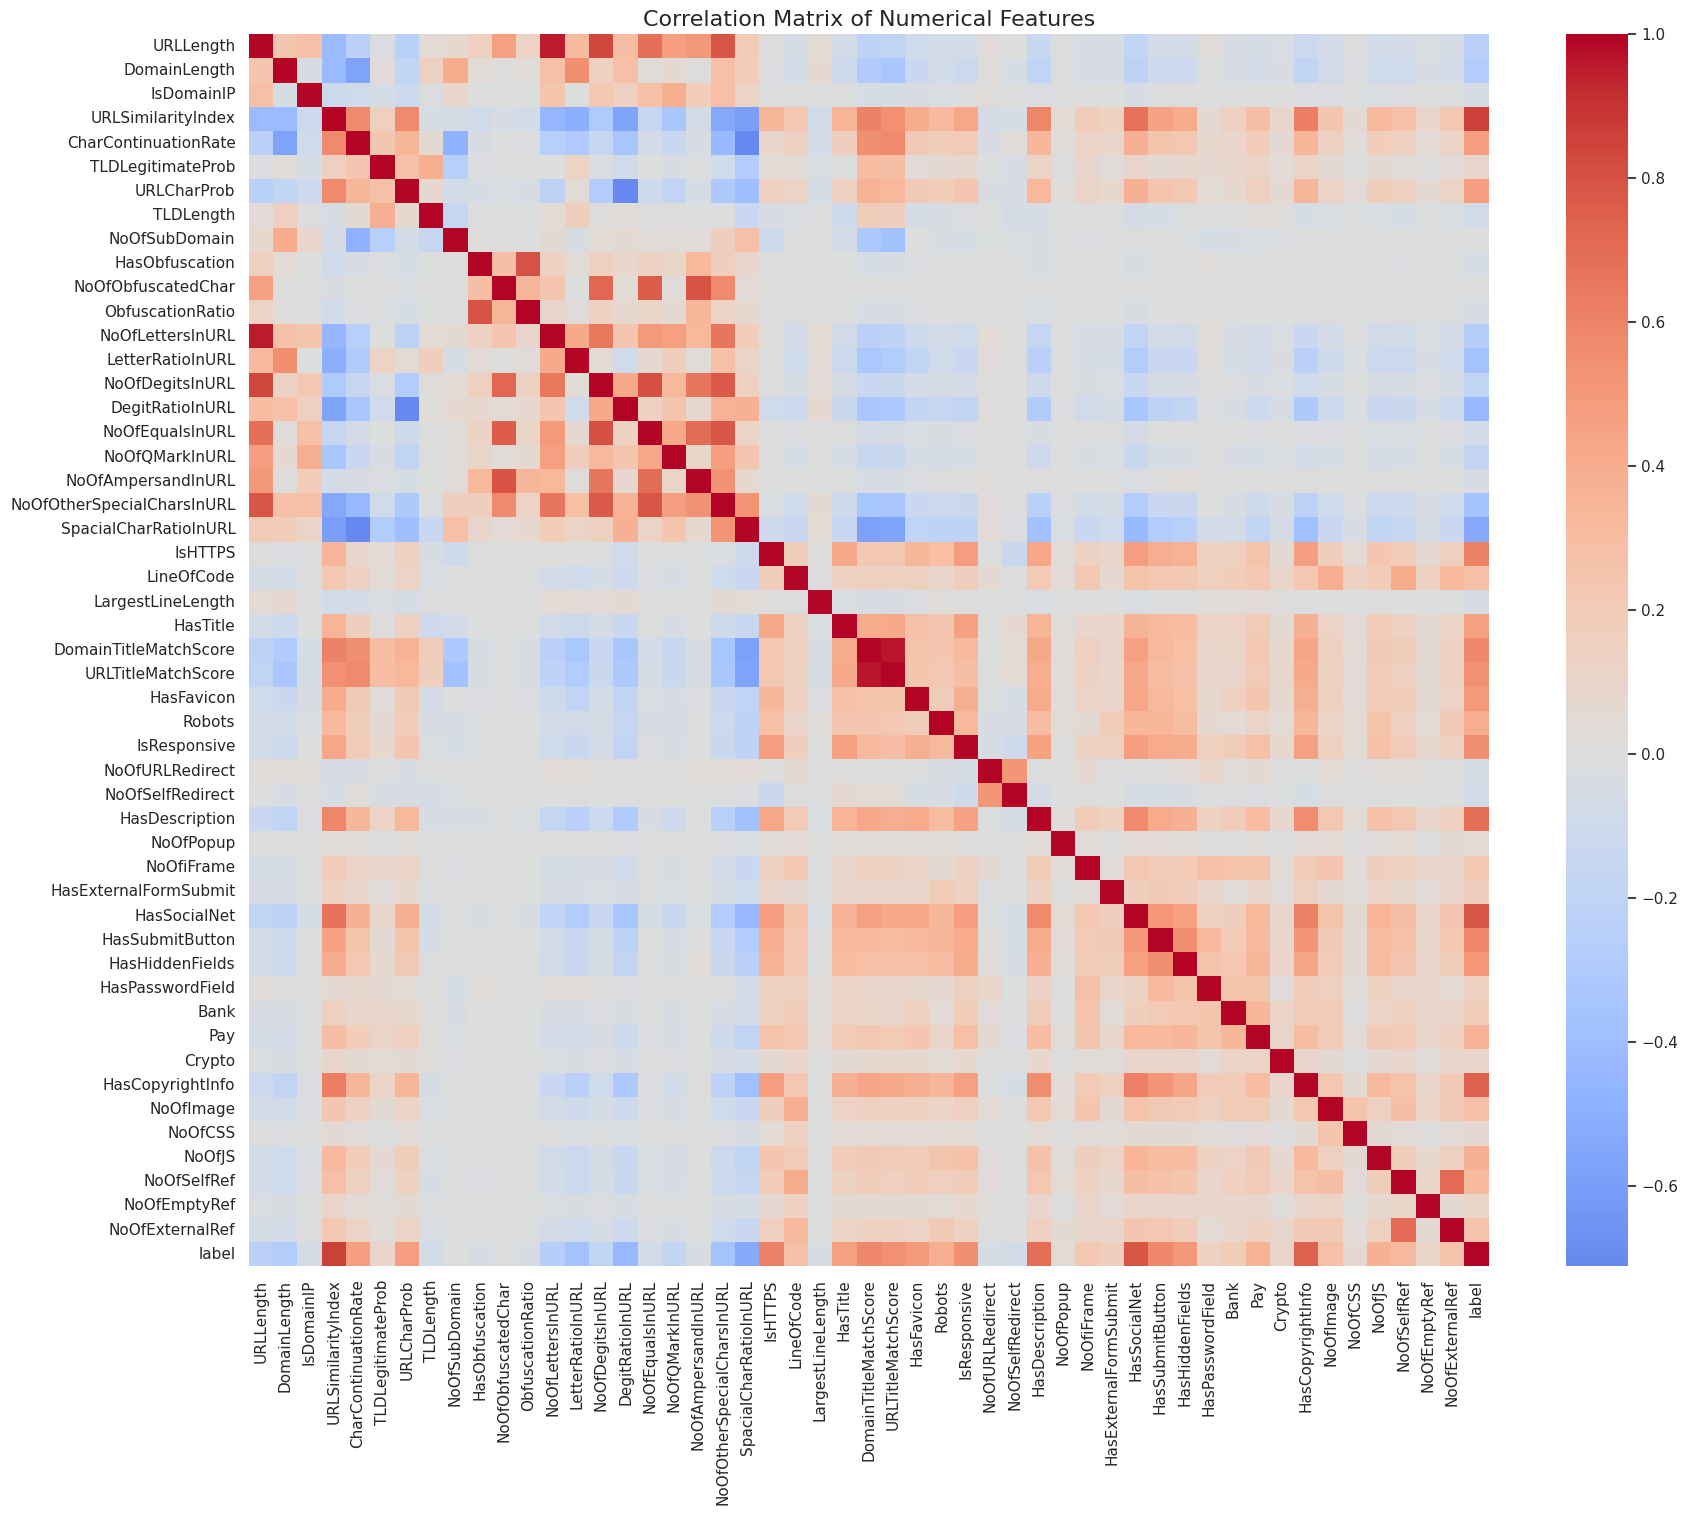


Top 20 features correlated with label:
label                    1.000000
URLSimilarityIndex       0.860342
HasSocialNet             0.783882
HasCopyrightInfo         0.743197
HasDescription           0.690011
IsHTTPS                  0.610253
DomainTitleMatchScore    0.584204
HasSubmitButton          0.578816
IsResponsive             0.548977
URLTitleMatchScore       0.538844
SpacialCharRatioInURL   -0.533003
HasHiddenFields          0.507715
HasFavicon               0.493607
URLCharProb              0.469521
CharContinuationRate     0.467162
HasTitle                 0.460337
DegitRatioInURL         -0.431896
Robots                   0.392461
NoOfJS                   0.373162
LetterRatioInURL        -0.366970
Name: label, dtype: float64


In [31]:
# Select numerical features for correlation analysis
numerical_features = df.select_dtypes(include=['int64', 'float64']).columns
correlation_matrix = df[numerical_features].corr()

plt.figure(figsize=(20, 16))
sns.heatmap(correlation_matrix, cmap='coolwarm', center=0, annot=False)
plt.title('Correlation Matrix of Numerical Features', fontsize=16)
plt.show()

# Top correlations with label
label_correlations = correlation_matrix['label'].sort_values(key=abs, ascending=False)
print("\nTop 20 features correlated with label:")
print(label_correlations.head(20))

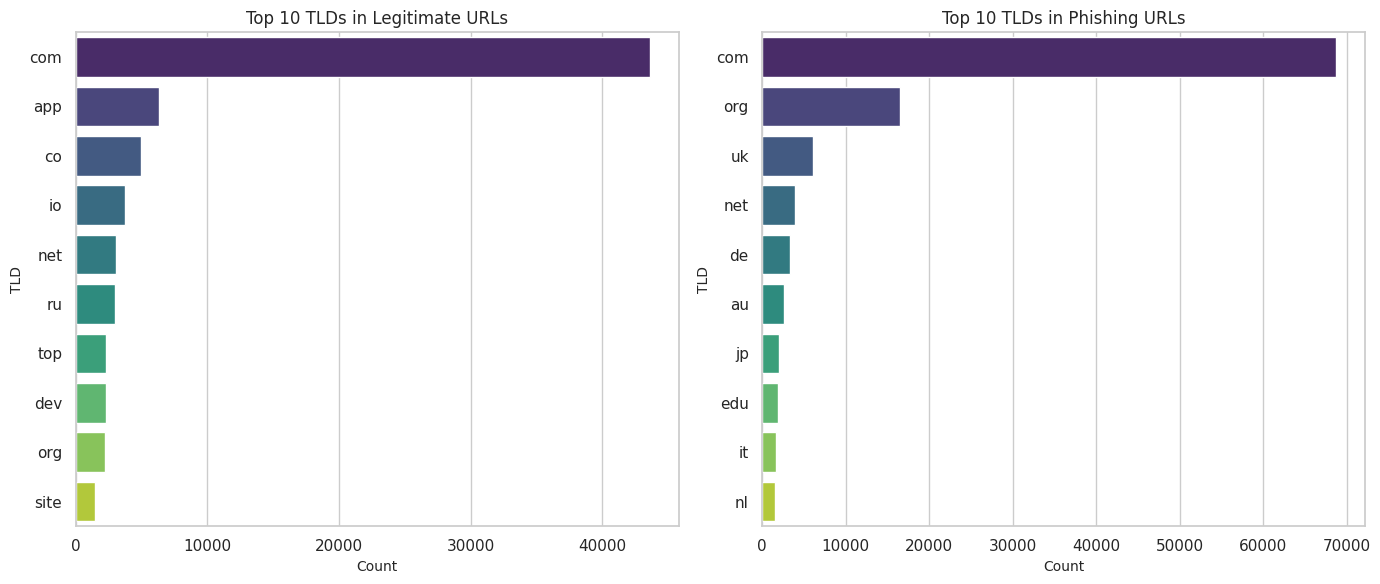

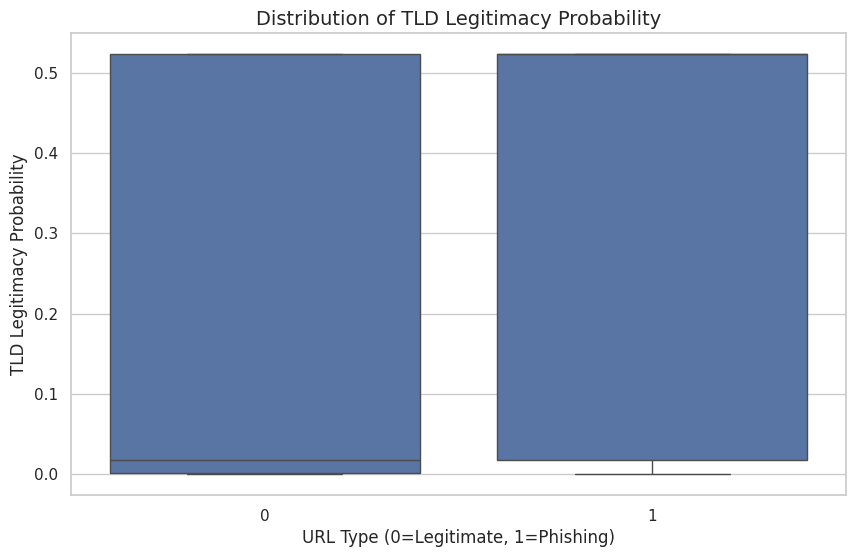


TLD Legitimacy Probability Statistics:
          count      mean       std           min       25%       50%  \
label                                                                   
0      100520.0  0.232167  0.254779  0.000000e+00  0.001502  0.018013   
1      134850.0  0.281625  0.247132  6.000000e-07  0.018013  0.522907   

            75%       max  
label                      
0      0.522907  0.522907  
1      0.522907  0.522907  

Mann-Whitney U test p-value: 0.0000


In [32]:
# Top TLDs in phishing vs legitimate
top_tlds = df['TLD'].value_counts().head(10).index

plt.figure(figsize=(14, 6))
for i, label in enumerate([0, 1]):
    plt.subplot(1, 2, i+1)
    tld_counts = df[df['label'] == label]['TLD'].value_counts().head(10)
    sns.barplot(x=tld_counts.values, y=tld_counts.index, palette='viridis')
    plt.title(f'Top 10 TLDs in {"Legitimate" if label == 0 else "Phishing"} URLs', fontsize=12)
    plt.xlabel('Count', fontsize=10)
    plt.ylabel('TLD', fontsize=10)

plt.tight_layout()
plt.show()

# TLD legitimacy probability comparison
plt.figure(figsize=(10, 6))
sns.boxplot(x='label', y='TLDLegitimateProb', data=df)
plt.title('Distribution of TLD Legitimacy Probability', fontsize=14)
plt.xlabel('URL Type (0=Legitimate, 1=Phishing)', fontsize=12)
plt.ylabel('TLD Legitimacy Probability', fontsize=12)
plt.show()

print("\nTLD Legitimacy Probability Statistics:")
print(df.groupby('label')['TLDLegitimateProb'].describe())
print(f"\nMann-Whitney U test p-value: {stats.mannwhitneyu(phishing['TLDLegitimateProb'], legitimate['TLDLegitimateProb']).pvalue:.4f}")


KEY FINDINGS

In [33]:
# Create a summary of key findings
key_findings = {
    "Structural Differences": {
        "URL Length": "Phishing URLs tend to be longer than legitimate ones (mean length: phishing={:.1f} vs legitimate={:.1f})".format(
            phishing['URLLength'].mean(), legitimate['URLLength'].mean()),
        "Subdomains": "Phishing URLs more frequently use multiple subdomains (mean count: phishing={:.1f} vs legitimate={:.1f})".format(
            phishing['NoOfSubDomain'].mean(), legitimate['NoOfSubDomain'].mean()),
        "Special Characters": "Phishing URLs contain more special characters (mean count: phishing={:.1f} vs legitimate={:.1f})".format(
            phishing['NoOfOtherSpecialCharsInURL'].mean(), legitimate['NoOfOtherSpecialCharsInURL'].mean())
    },
    "Security Indicators": {
        "HTTPS Usage": "Legitimate URLs more frequently use HTTPS ({:.1%} vs {:.1%} for phishing)".format(
            legitimate['IsHTTPS'].mean(), phishing['IsHTTPS'].mean()),
        "IP Address Usage": "Phishing URLs are more likely to use IP addresses instead of domain names ({:.2%} vs {:.2%} for legitimate)".format(
            phishing['IsDomainIP'].mean(), legitimate['IsDomainIP'].mean())
    },
    "Obfuscation": {
        "Obfuscation Present": "Phishing URLs are more likely to contain obfuscation techniques ({:.1%} vs {:.1%} for legitimate)".format(
            phishing['HasObfuscation'].mean(), legitimate['HasObfuscation'].mean()),
        "Character Continuation": "Phishing URLs have higher character continuation rates (mean: {:.2f} vs {:.2f})".format(
            phishing['CharContinuationRate'].mean(), legitimate['CharContinuationRate'].mean())
    },
    "Targeted Sectors": {
        "Banking Keywords": "Phishing URLs more frequently contain banking keywords ({:.1%} vs {:.1%})".format(
            phishing['Bank'].mean(), legitimate['Bank'].mean()),
        "Payment Keywords": "Phishing URLs more frequently contain payment keywords ({:.1%} vs {:.1%})".format(
            phishing['Pay'].mean(), legitimate['Pay'].mean()),
        "Crypto Keywords": "Phishing URLs more frequently contain cryptocurrency keywords ({:.1%} vs {:.1%})".format(
            phishing['Crypto'].mean(), legitimate['Crypto'].mean())
    }
}

print("="*80)
print("KEY FINDINGS SUMMARY".center(80))
print("="*80)

for category, findings in key_findings.items():
    print(f"\n{category}:")
    for feature, description in findings.items():
        print(f"- {feature}: {description}")

                              KEY FINDINGS SUMMARY                              

Structural Differences:
- URL Length: Phishing URLs tend to be longer than legitimate ones (mean length: phishing=26.2 vs legitimate=45.7)
- Subdomains: Phishing URLs more frequently use multiple subdomains (mean count: phishing=1.2 vs legitimate=1.2)
- Special Characters: Phishing URLs contain more special characters (mean count: phishing=1.2 vs legitimate=3.8)

Security Indicators:
- HTTPS Usage: Legitimate URLs more frequently use HTTPS (49.1% vs 100.0% for phishing)
- IP Address Usage: Phishing URLs are more likely to use IP addresses instead of domain names (0.00% vs 0.63% for legitimate)

Obfuscation:
- Obfuscation Present: Phishing URLs are more likely to contain obfuscation techniques (0.0% vs 0.5% for legitimate)
- Character Continuation: Phishing URLs have higher character continuation rates (mean: 0.93 vs 0.73)

Targeted Sectors:
- Banking Keywords: Phishing URLs more frequently contain banking

DATA PROCESSING

In [34]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest


MISSING VALUES

In [35]:

# Check for missing values
print("MISSING VALUES:")
print(df.isnull().sum(), "\n")

MISSING VALUES:
FILENAME                      0
URL                           0
URLLength                     0
Domain                        0
DomainLength                  0
IsDomainIP                    0
TLD                           0
URLSimilarityIndex            0
CharContinuationRate          0
TLDLegitimateProb             0
URLCharProb                   0
TLDLength                     0
NoOfSubDomain                 0
HasObfuscation                0
NoOfObfuscatedChar            0
ObfuscationRatio              0
NoOfLettersInURL              0
LetterRatioInURL              0
NoOfDegitsInURL               0
DegitRatioInURL               0
NoOfEqualsInURL               0
NoOfQMarkInURL                0
NoOfAmpersandInURL            0
NoOfOtherSpecialCharsInURL    0
SpacialCharRatioInURL         0
IsHTTPS                       0
LineOfCode                    0
LargestLineLength             0
HasTitle                      0
Title                         0
DomainTitleMatchScore   

TARGET VARIABLE SELECTION

In [36]:
X = df.drop(['label', 'FILENAME', 'URL', 'Domain', 'TLD', 'Title'], axis=1)
y = df['label']

HANDLING OUTLIERS

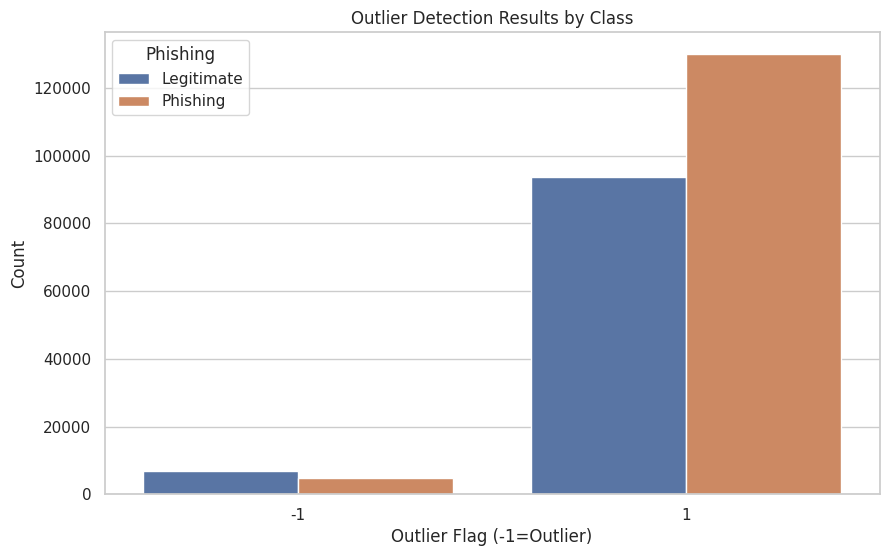

In [37]:
# 3. Outlier Detection with Isolation Forest (only on features, not target)
outlier_detector = IsolationForest(contamination=0.05, random_state=42)  # Adjust contamination as needed
outliers = outlier_detector.fit_predict(X)

# Visualize outlier detection results
plt.figure(figsize=(10, 6))
sns.countplot(x=outliers, hue=y)
plt.title('Outlier Detection Results by Class')
plt.xlabel('Outlier Flag (-1=Outlier)')
plt.ylabel('Count')
plt.legend(title='Phishing', labels=['Legitimate', 'Phishing'])
plt.show()

# 4. Outlier Treatment Options (uncomment your preferred approach)
# Option 1: Remove outliers
# X = X[outliers == 1]
# y = y[outliers == 1]

# Option 2: Cap outliers (winsorization)
def winsorize_columns(df, columns, lower_quantile=0.05, upper_quantile=0.95):
    for col in columns:
        lower = df[col].quantile(lower_quantile)
        upper = df[col].quantile(upper_quantile)
        df[col] = df[col].clip(lower, upper)
    return df

numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns
X = winsorize_columns(X.copy(), numeric_cols)


## 4. Feature Engineering


Final dataset shapes:
Training set: (164759, 51)
Test set: (70611, 51)

Class distribution in training set:
label
1    0.572928
0    0.427072
Name: proportion, dtype: float64

Class distribution in test set:
label
1    0.572928
0    0.427072
Name: proportion, dtype: float64


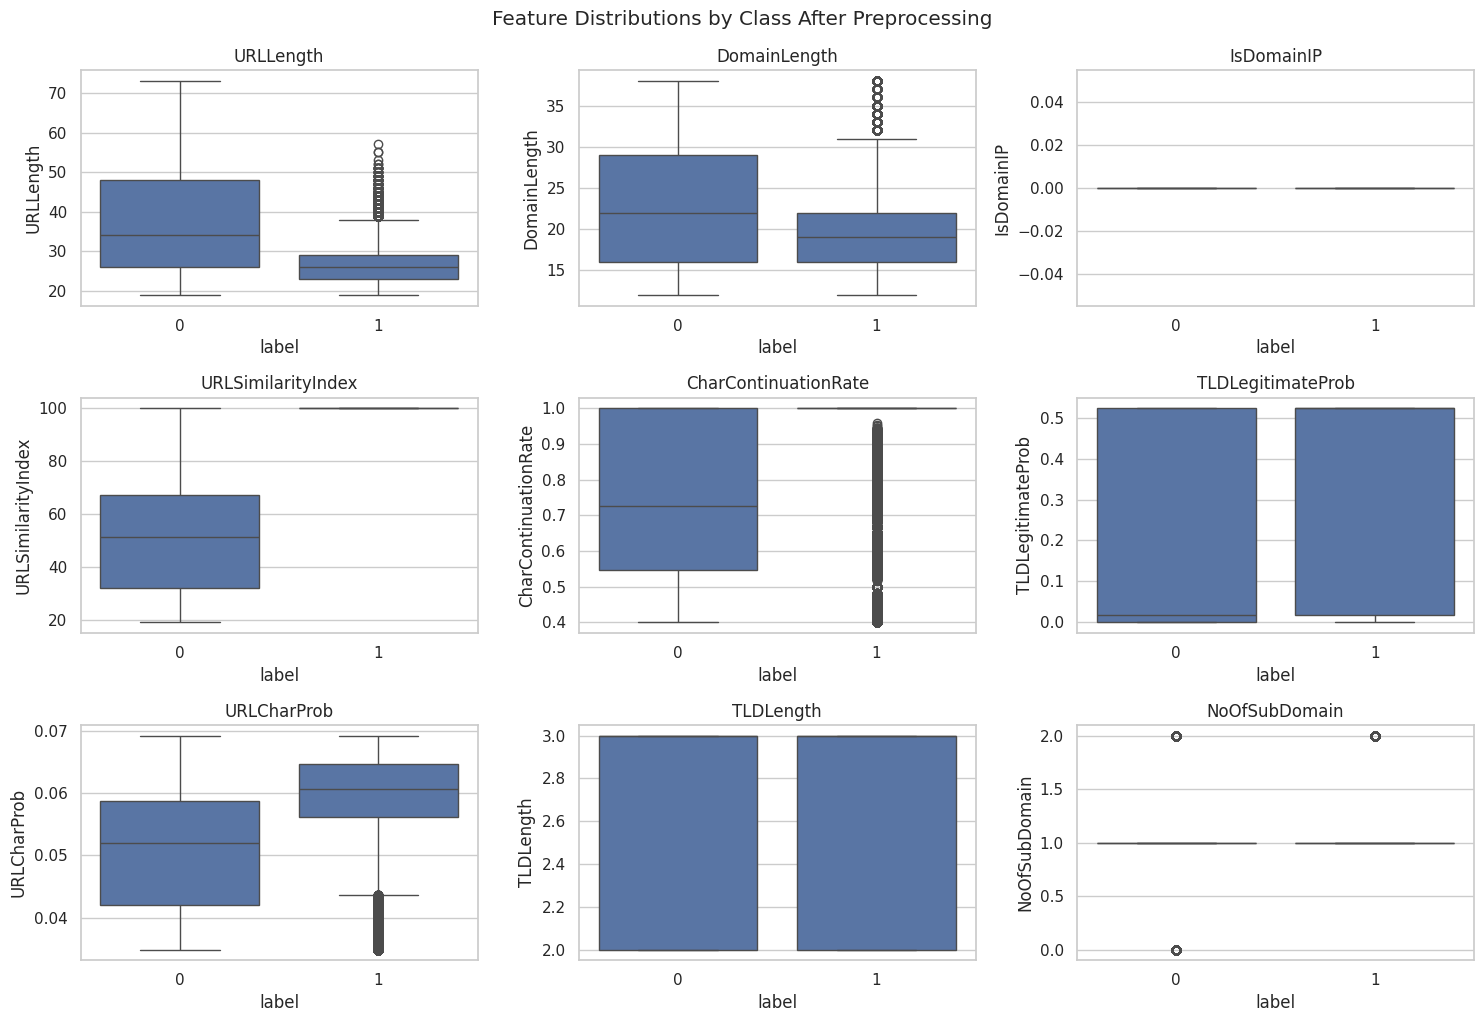

In [38]:
# 5. Feature Scaling (choose one approach)
# Standardization (for logistic regression, SVM)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# OR Normalization (for distance-based algorithms)
# scaler = MinMaxScaler()
# X_scaled = scaler.fit_transform(X)

# 6. Train-Test Split (stratified to preserve class distribution)
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.3, stratify=y, random_state=42)

# 7. Verify final distributions
print("\nFinal dataset shapes:")
print("Training set:", X_train.shape)
print("Test set:", X_test.shape)

print("\nClass distribution in training set:")
print(pd.Series(y_train).value_counts(normalize=True))

print("\nClass distribution in test set:")
print(pd.Series(y_test).value_counts(normalize=True))

# 8. Feature Distribution Visualization After Preprocessing
plt.figure(figsize=(15, 10))
for i, col in enumerate(numeric_cols[:9]):  # Plot first 9 features
    plt.subplot(3, 3, i+1)
    sns.boxplot(x=y, y=X[numeric_cols[i]])
    plt.title(col)
    plt.tight_layout()
plt.suptitle('Feature Distributions by Class After Preprocessing', y=1.02)
plt.show()


Remaining NaN values in training set: 0
Remaining NaN values in test set: 0


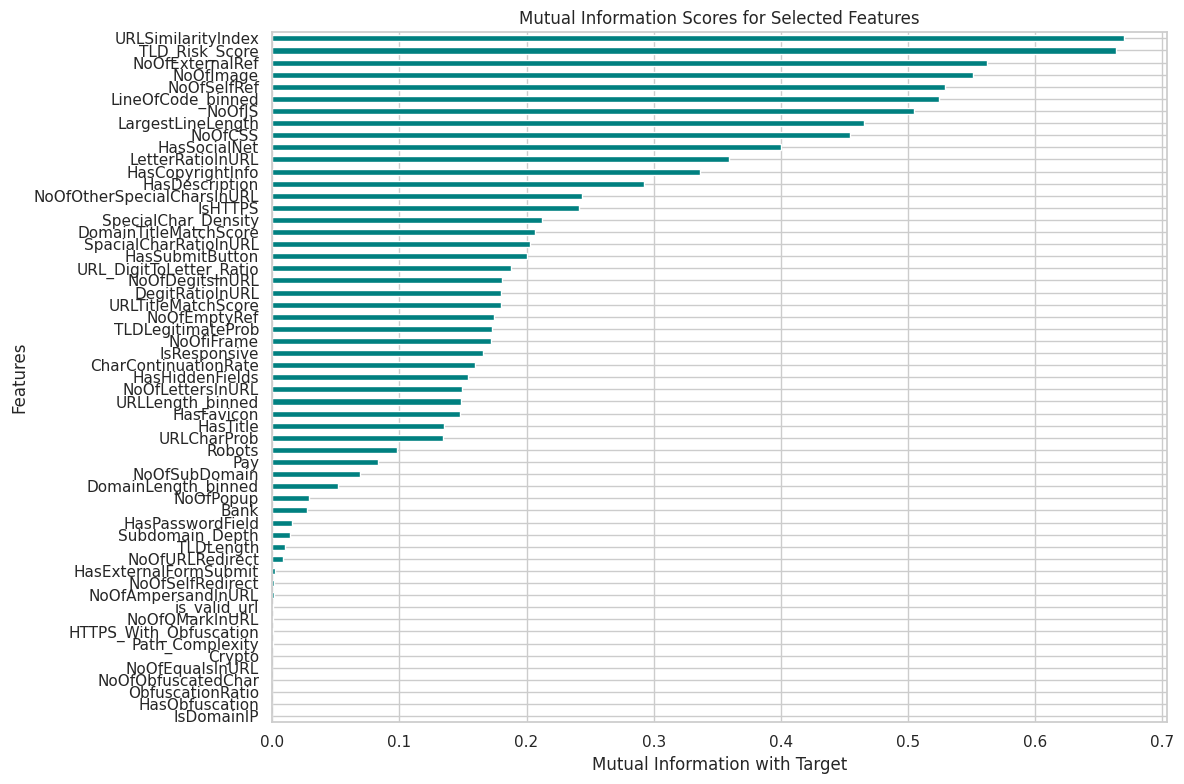

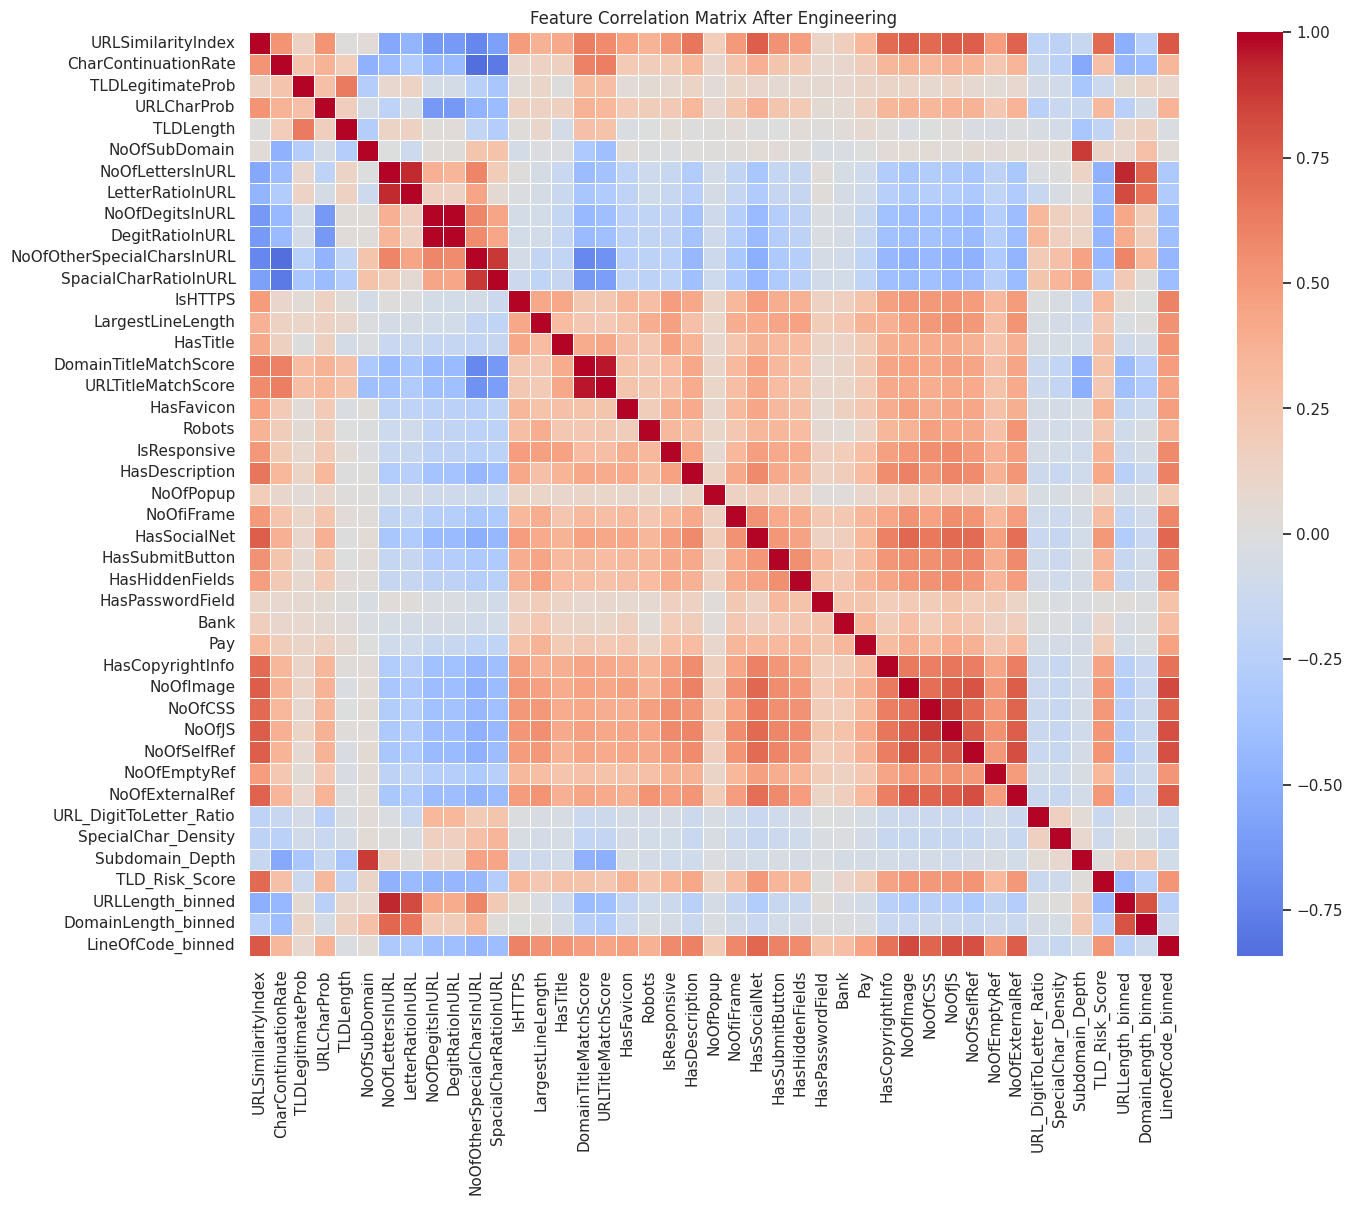


Top 10 Most Important Features:
URLSimilarityIndex    0.670348
TLD_Risk_Score        0.663525
NoOfExternalRef       0.562404
NoOfImage             0.551187
NoOfSelfRef           0.528867
LineOfCode_binned     0.524720
NoOfJS                0.504655
LargestLineLength     0.465242
NoOfCSS               0.454244
HasSocialNet          0.400248
dtype: float64

Final Feature Dimensions:
Training set: (164759, 43)
Test set: (70611, 43)


In [39]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import PowerTransformer, KBinsDiscretizer
from sklearn.feature_selection import mutual_info_classif
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Enhanced Feature Creation with NaN Protection
def extract_domain_features(df):
    # Make copy to avoid SettingWithCopyWarning
    df = df.copy()

    # Safe division with epsilon
    eps = 1e-8

    # URL structure features
    df['URL_DigitToLetter_Ratio'] = np.where(
        df['NoOfLettersInURL'] > 0,
        df['NoOfDegitsInURL'] / (df['NoOfLettersInURL'] + eps),
        0
    )

    df['SpecialChar_Density'] = np.where(
        df['URLLength'] > 0,
        df['NoOfOtherSpecialCharsInURL'] / (df['URLLength'] + eps),
        0
    )

    # Domain hierarchy features
    df['Subdomain_Depth'] = np.log1p(df['NoOfSubDomain'].clip(0, None))  # Clip negative values

    df['Path_Complexity'] = (
        df['NoOfEqualsInURL'].fillna(0) +
        df['NoOfQMarkInURL'].fillna(0) +
        df['NoOfAmpersandInURL'].fillna(0)
    )

    # Security features
    df['HTTPS_With_Obfuscation'] = df['IsHTTPS'] * df['HasObfuscation']

    df['TLD_Risk_Score'] = np.where(
        df['TLDLegitimateProb'].notna(),
        (1 - df['TLDLegitimateProb']) * df['URLSimilarityIndex'],
        0
    )

    return df

# 2. Robust Skewness Transformation
def transform_skewed_features(df, skew_threshold=0.5):
    df = df.copy()
    numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns

    # Skip binary/categorical columns
    exclude_cols = {'label', 'IsHTTPS', 'HasObfuscation'} & set(df.columns)
    numeric_cols = [col for col in numeric_cols if col not in exclude_cols]

    # Handle infinite values before skew calculation
    df[numeric_cols] = df[numeric_cols].replace([np.inf, -np.inf], np.nan)

    # Calculate skewness on non-null values
    skew_values = df[numeric_cols].apply(lambda x: x.skew() if x.notna().any() else 0)
    skewed_features = skew_values.abs() > skew_threshold

    # Apply Yeo-Johnson transform
    for col in skewed_features[skewed_features].index:
        pt = PowerTransformer(method='yeo-johnson')
        col_data = df[col].values.reshape(-1, 1)

        # Impute missing values temporarily for transformation
        imputer = SimpleImputer(strategy='median')
        col_data_imputed = imputer.fit_transform(col_data)

        # Transform
        transformed = pt.fit_transform(col_data_imputed)
        df[col] = transformed

    return df

# 3. Safe Discretization
def discretize_features(df):
    df = df.copy()
    discretize_cols = ['URLLength', 'DomainLength', 'LineOfCode']

    for col in discretize_cols:
        if col in df.columns:
            # Handle missing values
            if df[col].isna().any():
                imputer = SimpleImputer(strategy='median')
                df[col] = imputer.fit_transform(df[[col]])

            # Discretize
            est = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='quantile')
            df[col+'_binned'] = est.fit_transform(df[[col]])

    return df

# 4. Feature Selection with NaN Handling
def select_features(X, y, threshold=0.01):
    # Handle missing values
    imputer = SimpleImputer(strategy='median')
    X_imputed = imputer.fit_transform(X)

    # Calculate mutual information
    mi_scores = mutual_info_classif(X_imputed, y, random_state=42)
    mi_scores = pd.Series(mi_scores, index=X.columns)

    # Select features
    selected_features = mi_scores[mi_scores > threshold].index
    return X[selected_features], mi_scores

# 5. Robust Pipeline Execution
def feature_engineering_pipeline(df):
    # Create new features
    df = extract_domain_features(df)

    # Transformations
    df = transform_skewed_features(df)
    df = discretize_features(df)

    # Drop original columns that were discretized
    cols_to_drop = ['URLLength', 'DomainLength', 'LineOfCode']
    df = df.drop([col for col in cols_to_drop if col in df.columns], axis=1)

    # Final NaN check and imputation
    if df.isna().any().any():
        imputer = SimpleImputer(strategy='median')
        df = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)

    return df

# Convert numpy arrays back to DataFrames with column names
X_train_df = pd.DataFrame(X_train, columns=X.columns)
X_test_df = pd.DataFrame(X_test, columns=X.columns)

# Execute pipeline
X_train_fe = feature_engineering_pipeline(X_train_df)
X_test_fe = feature_engineering_pipeline(X_test_df)

# Feature selection
X_train_selected, mi_scores = select_features(X_train_fe, y_train)
selected_features = X_train_selected.columns
X_test_selected = X_test_fe[selected_features]

# Verify no NaN values remain
print("Remaining NaN values in training set:", X_train_selected.isna().sum().sum())
print("Remaining NaN values in test set:", X_test_selected.isna().sum().sum())

# Visualizations (same as before)
plt.figure(figsize=(12, 8))
mi_scores.sort_values(ascending=True).plot.barh(color='teal')
plt.title('Mutual Information Scores for Selected Features')
plt.xlabel('Mutual Information with Target')
plt.ylabel('Features')
plt.tight_layout()
plt.show()

plt.figure(figsize=(15, 12))
corr_matrix = X_train_selected.corr()
sns.heatmap(corr_matrix, cmap='coolwarm', center=0,
            annot=False, fmt=".1f", linewidths=.5)
plt.title('Feature Correlation Matrix After Engineering')
plt.show()

print("\nTop 10 Most Important Features:")
print(mi_scores.sort_values(ascending=False).head(10))
print("\nFinal Feature Dimensions:")
print("Training set:", X_train_selected.shape)
print("Test set:", X_test_selected.shape)

In [40]:
if df is not None:
    def extract_features(df):
        """Create URL features with proper Series operations"""
        try:
            df = df.copy()

            # Ensure URL is string type
            df['URL'] = df['URL'].astype(str)

            # Basic URL components (using Series.str accessor)
            df['url_length'] = df['URL'].str.len()
            df['num_special_chars'] = df['URL'].str.count(r'[^a-zA-Z0-9]')

            # Extract domain parts safely
            def get_domain_parts(url):
                try:
                    ext = tldextract.extract(str(url))
                    return pd.Series({
                        'subdomain': ext.subdomain,
                        'domain': ext.domain,
                        'suffix': ext.suffix,
                        'is_ip': 1 if re.match(r'^\d+\.\d+\.\d+\.\d+$', ext.domain) else 0
                    })
                except:
                    return pd.Series({
                        'subdomain': None,
                        'domain': None,
                        'suffix': None,
                        'is_ip': 0
                    })

            domain_parts = df['URL'].apply(get_domain_parts)
            df = pd.concat([df, domain_parts], axis=1)

            # Additional features (using Series where needed)
            df['subdomain_length'] = df['subdomain'].astype(str).str.len().fillna(0)
            df['has_https'] = df['URL'].str.startswith('https').astype(int)

            return df

        except Exception as e:
            print(f"Error in feature engineering: {str(e)}")
            return None

    df = extract_features(df)

    if df is not None:
        print("\nFeature engineering completed successfully.")
        print("New features added:",
              [col for col in df.columns if col not in ['URL', 'label', 'is_valid_url']])
        print("\nSample of engineered features:")
        display(df.head())
    else:
        print("Feature engineering failed.")
else:
    print("Skipping feature engineering - no data available.")



Feature engineering completed successfully.
New features added: ['FILENAME', 'URLLength', 'Domain', 'DomainLength', 'IsDomainIP', 'TLD', 'URLSimilarityIndex', 'CharContinuationRate', 'TLDLegitimateProb', 'URLCharProb', 'TLDLength', 'NoOfSubDomain', 'HasObfuscation', 'NoOfObfuscatedChar', 'ObfuscationRatio', 'NoOfLettersInURL', 'LetterRatioInURL', 'NoOfDegitsInURL', 'DegitRatioInURL', 'NoOfEqualsInURL', 'NoOfQMarkInURL', 'NoOfAmpersandInURL', 'NoOfOtherSpecialCharsInURL', 'SpacialCharRatioInURL', 'IsHTTPS', 'LineOfCode', 'LargestLineLength', 'HasTitle', 'Title', 'DomainTitleMatchScore', 'URLTitleMatchScore', 'HasFavicon', 'Robots', 'IsResponsive', 'NoOfURLRedirect', 'NoOfSelfRedirect', 'HasDescription', 'NoOfPopup', 'NoOfiFrame', 'HasExternalFormSubmit', 'HasSocialNet', 'HasSubmitButton', 'HasHiddenFields', 'HasPasswordField', 'Bank', 'Pay', 'Crypto', 'HasCopyrightInfo', 'NoOfImage', 'NoOfCSS', 'NoOfJS', 'NoOfSelfRef', 'NoOfEmptyRef', 'NoOfExternalRef', 'url_length', 'num_special_chars

,FILENAME,URL,URLLength,Domain,DomainLength,IsDomainIP,TLD,URLSimilarityIndex,CharContinuationRate,TLDLegitimateProb,...,label,is_valid_url,url_length,num_special_chars,subdomain,domain,suffix,is_ip,subdomain_length,has_https
0,521848.txt,https://www.southbankmosaics.com,31,www.southbankmosaics.com,24,0,com,100.0,1.000000,0.522907,...,1,True,32,5,www,southbankmosaics,com,0,3,1
1,31372.txt,https://www.uni-mainz.de,23,www.uni-mainz.de,16,0,de,100.0,0.666667,0.032650,...,1,True,24,6,www,uni-mainz,de,0,3,1
2,597387.txt,https://www.voicefmradio.co.uk,29,www.voicefmradio.co.uk,22,0,uk,100.0,0.866667,0.028555,...,1,True,30,6,www,voicefmradio,co.uk,0,3,1
3,554095.txt,https://www.sfnmjournal.com,26,www.sfnmjournal.com,19,0,com,100.0,1.000000,0.522907,...,1,True,27,5,www,sfnmjournal,com,0,3,1
4,151578.txt,https://www.rewildingargentina.org,33,www.rewildingargentina.org,26,0,org,100.0,1.000000,0.079963,...,1,True,34,5,www,rewildingargentina,org,0,3,1


## 5. Data Preprocessing

In [41]:
if df is not None:
    try:
        # Separate features and target
        X = df.drop(['label', 'URL', 'is_valid_url'], axis=1, errors='ignore')
        y = df['label']

        # Identify feature types
        numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
        categorical_features = X.select_dtypes(include=['object']).columns

        print("Numeric features:", numeric_features.tolist())
        print("Categorical features:", categorical_features.tolist())

        # Preprocessing pipelines
        numeric_transformer = Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ])

        categorical_transformer = Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
            ('onehot', OneHotEncoder(handle_unknown='ignore'))
        ])

        preprocessor = ColumnTransformer(
            transformers=[
                ('num', numeric_transformer, numeric_features),
                ('cat', categorical_transformer, categorical_features)
            ])

        print("\nPreprocessing setup completed successfully.")

    except Exception as e:
        print(f"Error in preprocessing setup: {str(e)}")
        X, y = None, None
else:
    print("Skipping preprocessing - no data available.")
    X, y = None, None

Numeric features: ['URLLength', 'DomainLength', 'IsDomainIP', 'URLSimilarityIndex', 'CharContinuationRate', 'TLDLegitimateProb', 'URLCharProb', 'TLDLength', 'NoOfSubDomain', 'HasObfuscation', 'NoOfObfuscatedChar', 'ObfuscationRatio', 'NoOfLettersInURL', 'LetterRatioInURL', 'NoOfDegitsInURL', 'DegitRatioInURL', 'NoOfEqualsInURL', 'NoOfQMarkInURL', 'NoOfAmpersandInURL', 'NoOfOtherSpecialCharsInURL', 'SpacialCharRatioInURL', 'IsHTTPS', 'LineOfCode', 'LargestLineLength', 'HasTitle', 'DomainTitleMatchScore', 'URLTitleMatchScore', 'HasFavicon', 'Robots', 'IsResponsive', 'NoOfURLRedirect', 'NoOfSelfRedirect', 'HasDescription', 'NoOfPopup', 'NoOfiFrame', 'HasExternalFormSubmit', 'HasSocialNet', 'HasSubmitButton', 'HasHiddenFields', 'HasPasswordField', 'Bank', 'Pay', 'Crypto', 'HasCopyrightInfo', 'NoOfImage', 'NoOfCSS', 'NoOfJS', 'NoOfSelfRef', 'NoOfEmptyRef', 'NoOfExternalRef', 'url_length', 'num_special_chars', 'is_ip', 'subdomain_length', 'has_https']
Categorical features: ['FILENAME', 'Doma

 Enhanced Model Training with 8 Algorithms and Confusion Matrix Visualization



In [44]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
import time

## 6. Model Training


=== Training Random Forest ===
Training time: 580.04s
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000
ROC AUC: 1.0000


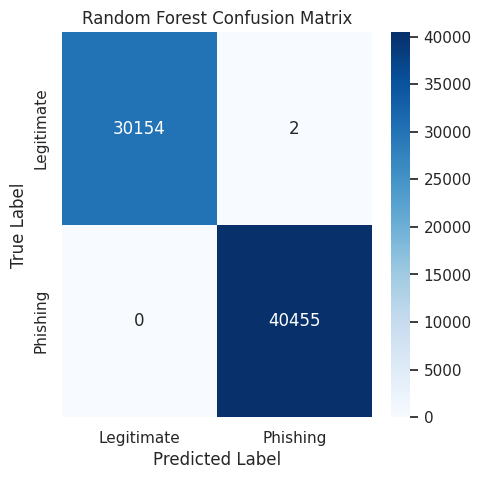


Classification Report:
              precision    recall  f1-score   support

  Legitimate       1.00      1.00      1.00     30156
    Phishing       1.00      1.00      1.00     40455

    accuracy                           1.00     70611
   macro avg       1.00      1.00      1.00     70611
weighted avg       1.00      1.00      1.00     70611


=== Training XGBoost ===
Training time: 48.44s
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000
ROC AUC: 1.0000


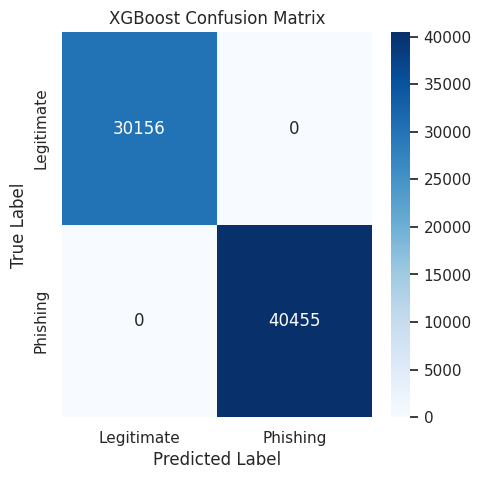


Classification Report:
              precision    recall  f1-score   support

  Legitimate       1.00      1.00      1.00     30156
    Phishing       1.00      1.00      1.00     40455

    accuracy                           1.00     70611
   macro avg       1.00      1.00      1.00     70611
weighted avg       1.00      1.00      1.00     70611


=== Training LightGBM ===
[LightGBM] [Info] Number of positive: 94395, number of negative: 70364
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.545350 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6591
[LightGBM] [Info] Number of data points in the train set: 164759, number of used features: 755
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.572928 -> initscore=0.293806
[LightGBM] [Info] Start training from score 0.293806
[LightGBM] [Warning] No further splits with positive gain, best 

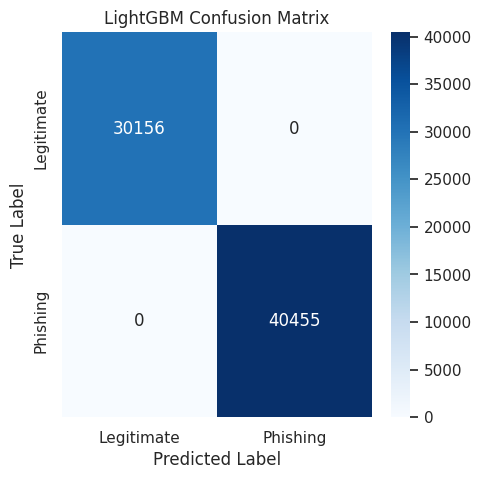


Classification Report:
              precision    recall  f1-score   support

  Legitimate       1.00      1.00      1.00     30156
    Phishing       1.00      1.00      1.00     40455

    accuracy                           1.00     70611
   macro avg       1.00      1.00      1.00     70611
weighted avg       1.00      1.00      1.00     70611


=== Training SVM ===
Training time: 1539.55s
Accuracy: 0.9999
Precision: 0.9998
Recall: 1.0000
F1 Score: 0.9999
ROC AUC: 1.0000


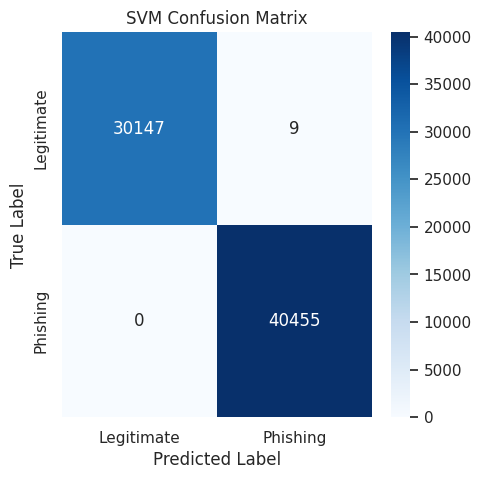


Classification Report:
              precision    recall  f1-score   support

  Legitimate       1.00      1.00      1.00     30156
    Phishing       1.00      1.00      1.00     40455

    accuracy                           1.00     70611
   macro avg       1.00      1.00      1.00     70611
weighted avg       1.00      1.00      1.00     70611


=== Training Logistic Regression ===
Training time: 16.23s
Accuracy: 0.9999
Precision: 0.9999
Recall: 1.0000
F1 Score: 0.9999
ROC AUC: 1.0000


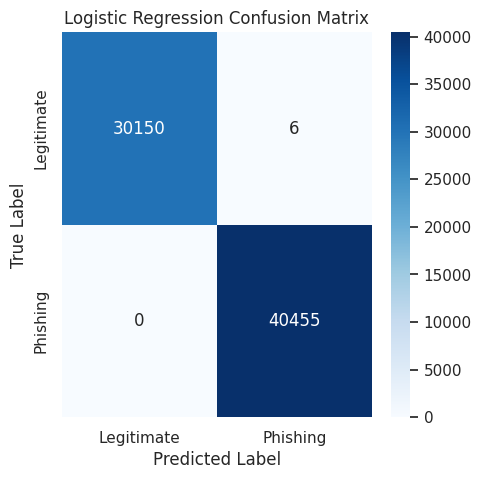


Classification Report:
              precision    recall  f1-score   support

  Legitimate       1.00      1.00      1.00     30156
    Phishing       1.00      1.00      1.00     40455

    accuracy                           1.00     70611
   macro avg       1.00      1.00      1.00     70611
weighted avg       1.00      1.00      1.00     70611


=== Training Decision Tree ===
Training time: 15.35s
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000
ROC AUC: 1.0000


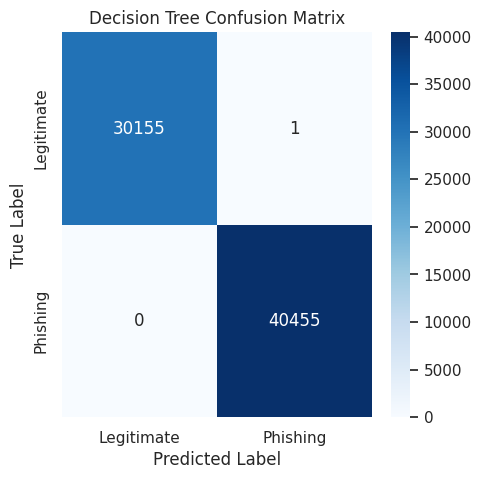


Classification Report:
              precision    recall  f1-score   support

  Legitimate       1.00      1.00      1.00     30156
    Phishing       1.00      1.00      1.00     40455

    accuracy                           1.00     70611
   macro avg       1.00      1.00      1.00     70611
weighted avg       1.00      1.00      1.00     70611


=== Training K-Nearest Neighbors ===
Training time: 5112.67s
Accuracy: 0.9990
Precision: 0.9984
Recall: 0.9998
F1 Score: 0.9991
ROC AUC: 0.9996


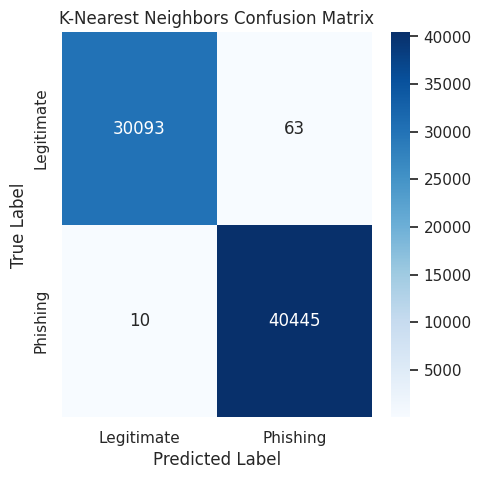


Classification Report:
              precision    recall  f1-score   support

  Legitimate       1.00      1.00      1.00     30156
    Phishing       1.00      1.00      1.00     40455

    accuracy                           1.00     70611
   macro avg       1.00      1.00      1.00     70611
weighted avg       1.00      1.00      1.00     70611


=== Training AdaBoost ===
Training time: 97.11s
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000
ROC AUC: 1.0000


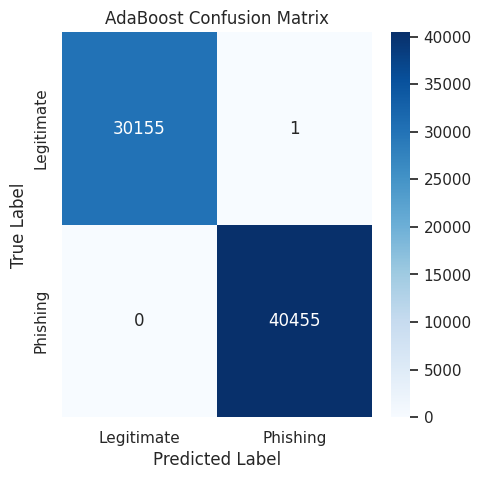


Classification Report:
              precision    recall  f1-score   support

  Legitimate       1.00      1.00      1.00     30156
    Phishing       1.00      1.00      1.00     40455

    accuracy                           1.00     70611
   macro avg       1.00      1.00      1.00     70611
weighted avg       1.00      1.00      1.00     70611


Best model: XGBoost with F1 score: 1.0000


In [45]:

if X is not None and y is not None:
    try:
        # Train-test split
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.3, stratify=y, random_state=42)

        # Expanded model collection with 8 algorithms
        models = {
            "Random Forest": RandomForestClassifier(random_state=42),
            "XGBoost": XGBClassifier(random_state=42, eval_metric='logloss'),
            "LightGBM": LGBMClassifier(random_state=42),
            "SVM": SVC(probability=True, random_state=42),
            "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
            "Decision Tree": DecisionTreeClassifier(random_state=42),
            "K-Nearest Neighbors": KNeighborsClassifier(),
            "AdaBoost": AdaBoostClassifier(random_state=42)
        }

        # Train and evaluate each model
        model_results = {}
        for name, model in models.items():
            print(f"\n=== Training {name} ===")
            start_time = time.time()

            pipeline = Pipeline(steps=[
                ('preprocessor', preprocessor),
                ('classifier', model)
            ])

            pipeline.fit(X_train, y_train)
            y_pred = pipeline.predict(X_test)
            y_proba = pipeline.predict_proba(X_test)[:, 1]

            # Calculate metrics
            accuracy = accuracy_score(y_test, y_pred)
            precision = precision_score(y_test, y_pred)
            recall = recall_score(y_test, y_pred)
            f1 = f1_score(y_test, y_pred)
            roc_auc = roc_auc_score(y_test, y_proba)
            training_time = time.time() - start_time

            # Store results
            model_results[name] = {
                'model': pipeline,
                'accuracy': accuracy,
                'precision': precision,
                'recall': recall,
                'f1': f1,
                'roc_auc': roc_auc,
                'time': training_time
            }

            # Print metrics
            print(f"Training time: {training_time:.2f}s")
            print(f"Accuracy: {accuracy:.4f}")
            print(f"Precision: {precision:.4f}")
            print(f"Recall: {recall:.4f}")
            print(f"F1 Score: {f1:.4f}")
            print(f"ROC AUC: {roc_auc:.4f}")

            # Plot confusion matrix
            cm = confusion_matrix(y_test, y_pred)
            plt.figure(figsize=(5, 5))
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                        xticklabels=['Legitimate', 'Phishing'],
                        yticklabels=['Legitimate', 'Phishing'])
            plt.title(f'{name} Confusion Matrix')
            plt.ylabel('True Label')
            plt.xlabel('Predicted Label')
            plt.show()

            # Print classification report
            print("\nClassification Report:")
            print(classification_report(y_test, y_pred, target_names=['Legitimate', 'Phishing']))

        # Select best model based on F1 score
        best_model_name = max(model_results, key=lambda x: model_results[x]['f1'])
        best_model = model_results[best_model_name]['model']
        print(f"\nBest model: {best_model_name} with F1 score: {model_results[best_model_name]['f1']:.4f}")

    except Exception as e:
        print(f"Error in model training: {str(e)}")
        best_model = None
else:
    print("Skipping model training - no data available.")
    best_model = None

## 7. Save Model (if training succeeded) and  Example Usage (if model exists)

In [46]:
if best_model is not None:
    try:
        # Recreate the exact same features used during training
        def extract_features_for_prediction(url):
            """Create features matching the training set structure"""
            try:
                # Create a single-row DataFrame to match training structure
                data = pd.DataFrame({
                    'URL': [url],
                    'label': [0]
                })

                # Basic URL components
                data['url_length'] = data['URL'].str.len()
                data['num_special_chars'] = data['URL'].str.count(r'[^a-zA-Z0-9]')

                # Extract domain parts
                def get_domain_parts(url):
                    try:
                        ext = tldextract.extract(str(url))
                        return pd.Series({
                            'subdomain': ext.subdomain,
                            'domain': ext.domain,
                            'suffix': ext.suffix,
                            'is_ip': 1 if re.match(r'^\d+\.\d+\.\d+\.\d+$', ext.domain) else 0
                        })
                    except:
                        return pd.Series({
                            'subdomain': None,
                            'domain': None,
                            'suffix': None,
                            'is_ip': 0
                        })

                domain_parts = data['URL'].apply(get_domain_parts)
                data = pd.concat([data, domain_parts], axis=1)

                # Additional features
                data['subdomain_length'] = data['subdomain'].astype(str).str.len().fillna(0)
                data['has_https'] = data['URL'].str.startswith('https').astype(int)

                # Add all missing columns from training set with default values
                training_columns = X.columns
                for col in training_columns:
                    if col not in data.columns:
                        data[col] = 0  # Fill missing columns with 0

                # Ensure column order matches training
                data = data[training_columns]

                return data

            except Exception as e:
                print(f"Feature extraction error: {str(e)}")
                return None

        # Example prediction function
        def predict_url(url):
            """Make prediction for a single URL"""
            try:
                # Extract features matching training set
                features = extract_features_for_prediction(url)
                if features is None:
                    return "Error: Could not extract features"

                # Make prediction
                prediction = best_model.predict(features)
                proba = best_model.predict_proba(features)

                # Fixed the parentheses here - removed the extra closing parenthesis
                return {
                    'url': url,
                    'prediction': 'Phishing' if prediction[0] else 'Legitimate',
                    'confidence': float(proba[0][1] if prediction[0] else proba[0][0])
                }
            except Exception as e:
                return f"Prediction error: {str(e)}"

        # Test some URLs
        test_urls = [
            "https://www.paypal.com.login.security.verify-account.com/secure/login",
            "https://www.google.com",
            "https://www.amazon.com",
            "http://malicious.example.com/login.php",
            "https://www.legitimate-bank.com"
        ]

        print("\nTesting sample URLs:")
        for url in test_urls:
            result = predict_url(url)
            if isinstance(result, dict):
                print(f"\nURL: {result['url']}")
                print(f"Prediction: {result['prediction']}")
                print(f"Confidence: {result['confidence']:.2%}")
            else:
                print(f"\nError with {url}: {result}")

    except Exception as e:
        print(f"Error in example prediction: {str(e)}")
else:
    print("No model available for example predictions.")


Testing sample URLs:

URL: https://www.paypal.com.login.security.verify-account.com/secure/login
Prediction: Legitimate
Confidence: 100.00%

URL: https://www.google.com
Prediction: Legitimate
Confidence: 100.00%

URL: https://www.amazon.com
Prediction: Legitimate
Confidence: 100.00%

URL: http://malicious.example.com/login.php
Prediction: Legitimate
Confidence: 100.00%

URL: https://www.legitimate-bank.com
Prediction: Legitimate
Confidence: 100.00%


## 8. Save Model

In [47]:
if best_model is not None:
    try:
        joblib.dump(best_model, 'phishing_model.pkl')
        with open('feature_names.json', 'w') as f:
            json.dump(list(X.columns), f)
        print("Model and features saved.")
    except Exception as e:
        print(f"Saving error: {str(e)}")

Model and features saved.
